We consider the multidimensional negative logarithm function
$$
f(x) = - \sum_{i=1}^d \log (x_i),
$$
defined on the positive orthant $\{x \in \mathbb{R}^d : x_i > 0 \text{ for all } i\}$, but restricted to the open hypercube $C = (10^{-3}, 10^{-1})^d$ as discussed earlier. This time, we train the approximating ICNN on a training set $\tilde{X} \subseteq C$ obtained as $\tilde{X} = \phi_{\hat{v}}(\tilde{Y})$ from a uniform sample $\tilde{Y}$ in the gradient space $D$ through a neural network approximation $\phi_{\hat{v}}$ of the inverse of $\nabla f$. The neural network $\phi_{\theta} \colon \mathbb{R}^d \to \mathbb{R}^d$ used here has $\tanh$ activation and three hidden layers of sizes $[128,128]$.

For Table \ref{tab:3} it shows estimates of the $L^2$-approximation errors
$$
\|\nabla f \circ \phi_{\hat{v}} - \text{id}\|_{L^2(D , \text{Unif})} \quad \text{and} \quad \|h_{\hat{\theta}} - f^*\|_{L^2(D , \text{Unif})}
$$
along with the times in hours, minutes, and seconds it took to train $\phi_{\hat{v}}$ and $h_{\hat{\theta}}$.

It can be seen that the approximation of $f^*$ is more accurate compared to the direct sampling method. However, the time to train $h_{\hat{\theta}}$ has increased since indirect sampling involves an evaluation of the neural network $\phi_{\hat{v}}$ in the simulation of every random point $x \in \tilde{X}$.

Libraries: JAX.


In [ ]:
# !pip install optax

In [ ]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import random, vmap, lax
from jax.tree_util import tree_leaves
import optax
import matplotlib.pyplot as plt
import yaml
import os
import time
import sys
import json
from scipy.io import savemat
from tqdm import tqdm
from collections import namedtuple
from functools import partial
from typing import Callable, Any, List

# Flax library imports
from flax import linen as nn
from flax.training import train_state


In [ ]:
DPI = 100  # dpi = 300  # Set DPI for higher quality images


In [ ]:
base_path = "/content/drive/MyDrive/ETH/Convex_conjugates/experiments_with_ICNN_2"
 # results of experiments with ICNN that use nonlinear transform to ensure convexity
sys.path.append(base_path)

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Primal QUADRATIC:
def square(x):
    return jnp.reshape(jnp.sum(x*x, -1), ())
# Dual:
square_star_true = lambda x: jnp.sum(x*x, -1) / 4

#########################
# Primal NEGATIVE-ENTROPY
def negative_entropy(x):
    return jnp.reshape(jnp.sum(x * jnp.log(x), -1), ())
# Dual
negative_entropy_star_true = lambda x: jnp.sum(jnp.exp(x - 1), -1)

##########################
# Primal Negative Logarithm
def negative_logarithm(x):
    return -jnp.sum(jnp.log(x), axis=-1)

# Dual of the Negative Logarithm
def negative_logarithm_star_true(y):
    return -jnp.sum(jnp.log(-y), axis=-1) - y.shape[-1]



In [ ]:
class NonNegativeDense(nn.Module):
    features: int
    use_bias: bool = True
    dtype: Any = None
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros
    pre_transform: Callable = jnp.square # Optional pre-transformation

    @nn.compact
    def __call__(self, inputs):
        kernel_shape = (inputs.shape[-1], self.features)
        kernel = self.param('kernel', self.kernel_init, kernel_shape)
        # if self.pre_transform:
        kernel = self.pre_transform(kernel)  # Apply pre-transformation if any
         # Squaring the kernel to ensure non-negative weights
        y = jnp.dot(inputs, kernel)
        if self.use_bias:
            bias = self.param('bias', self.bias_init, (self.features,))
            y += bias
        return y

class ConvexNN(nn.Module):
    layer_widths: List[int]
    activation: Callable = nn.relu  # Default activation; adjust as needed

    @nn.compact
    def __call__(self, x):
        # Adjust to handle specific transformations for the first and last layers if needed
        for i, width in enumerate(self.layer_widths):
            # Use NonNegativeDense with optional pre_transform for the last layer
            if i == 0:  # First layer, using standard nn.Dense
                x = nn.Dense(features=width)(x)
            else:  # Intermediate layers with NonNegativeDense without pre_transform
                x = NonNegativeDense(features=width)(x)
            x = self.activation(x)

        # Final output layer, assuming a single output unit for simplicity
        x = NonNegativeDense(features=1)(x)  # Adjust if different behavior is desired
        return x

def gelu(x):
    return 0.5 * x * (1 + jax.scipy.special.erf(x / jnp.sqrt(2)))

class FCNN(nn.Module):
    layer_widths: List[int]
    activation: Callable = gelu# nn.relu  # Default activation; adjust as needed

    @nn.compact
    def __call__(self, x):
        # Adjust to handle specific transformations for the first and last layers if needed
        for i, width in enumerate(self.layer_widths):
            # Use NonNegativeDense with optional pre_transform for the last layer
            if i > -1:  # First layer, using standard nn.Dense
                x = nn.Dense(features=width)(x)
            else:  # Intermediate layers with NonNegativeDense without pre_transform
                x = NonNegativeDense(features=width)(x)
            x = self.activation(x)

        # Final output layer, assuming a single output unit for simplicity
        x = NonNegativeDense(features=1)(x)  # Adjust if different behavior is desired
        return x



class BNFCNN(nn.Module):
    layer_widths: List[int]
    activation: Callable = gelu #nn.relu  # Default activation; can be customized

    @nn.compact
    def __call__(self, x, train: bool = True):
        for i, width in enumerate(self.layer_widths):
            x = nn.Dense(features=width)(x)
            if i < len(self.layer_widths) - 1:  # Apply BatchNorm and activation to all but the last layer
                x = nn.BatchNorm(use_running_average=not train, momentum=0.9, epsilon=1e-5)(x)
                x = self.activation(x)
        return x

# Configuration Parameters

- **experiment_name**: A string used to uniquely identify and track the experiment.
- **description**: A string describing the purpose or details of the experiment.
- **dim**: An integer representing the dimensionality of the input space.
- **layer_widths**: A list of integers specifying the number of units in each layer of the neural network.
- **num_epochs**: An integer representing the number of epochs to train the model.
- **batch_size**: An integer specifying the size of each training batch.
- **steps**: An integer representing the number of steps the model takes per batch, relevant when mini-batch optimization is used (i.e., when `use_grid` is False).
- **start**: A float or list of floats representing the start point(s) of the rectangular domain for the primal variables \( x \).
- **end**: A float or list of floats representing the end point(s) of the rectangular domain for the primal variables \( x \).
- **convrg_eps**: A float specifying the convergence threshold epsilon for stopping the training.
- **learning_rate**: A float representing the learning rate for the optimizer.
- **l2_regularization_coefficient**: A float for the L2 regularization term to prevent overfitting.
- **N_ae**: An integer specifying the number of epochs for pretraining an autoencoder, if applicable.
- **v_init_fn**: A callable function for initializing the parameters. For instance, it could be a function that generates random values within a certain range.
- **minval**: A float or list of floats indicating the minimum value(s) for the gradient domain, corresponding to the dual variables \( y \).
- **maxval**: A float or list of floats indicating the maximum value(s) for the gradient domain, corresponding to the dual variables \( y \).
- **y_func**: A callable function defining the behavior or computation of the dual variables \( y \).
- **y_func_star**: A callable function representing the true conjugate of \( y \).

## Domain Explanation

- **Primal Domain (`start` to `end`)**: The domain for the primal variables \( x \) is defined as \([start, end]^d\).
- **Dual Domain (`minval` to `maxval`)**: The domain for the dual variables \( y \) is defined as \([minval, maxval]^d\).

The correct transformation between the domains is $\nabla f: H \to K$  and $\nabla^{-1} f: K\to H$ realized below with approximate inverse mappings.

In [ ]:
LEARNING_RATE = 3e-4
ALPHA = 1e-8 #

Config = namedtuple("Config",
                    [
                     "experiment_name",        # Name of the experiment for tracking purposes
                     "description",            # Description of the experiment
                     "dim",                    # Dimensionality of the input space
                     "layer_widths",           # Widths of each layer in the neural network
                     "num_epochs",             # Number of epochs for training
                     "batch_size",             # Batch size for training
                     "steps",                  # Number of steps per batch (useful if use_grid is False)
                     "start",                  # Start point of the primal domain (rectangular domain start)
                     "end",                    # End point of the primal domain (rectangular domain end)
                     "convrg_eps",             # Convergence epsilon for stopping criterion
                    "ae_convrg_eps",             # Convergence epsilon for stopping criterion for ae
                     "learning_rate",          # Starting value of the learning rate for the optimizer
                     "learning_rate_ae",
                     "N_ae",                   # Number of epochs for autoencoder pretraining
                     "v_init_fn",              # Initialization function for the parameters
                     "minval",                 # Minimum value for the gradient domain (dual domain start)
                     "maxval",                 # Maximum value for the gradient domain (dual domain end)
                     "f_func",                 # Function definition for y (dual variables)
                     "f_func_star",             # True function conjugate for y
                     "train_sampling",         # use inverse sampling for train
                     "test_sampling"           # use inverse sampling for test
                    ])




In [ ]:
cfg = Config(
    experiment_name = "Negative_LOG_inverse_sampling_d=20",               # Name of the experiment for tracking purposes
    description = "Negative_LOG_inverse_sampling_d=20",        # Description of the experiment
    dim = 20,                               # Dimensionality of the input space
    layer_widths = (256, 256),           # Widths of each layer in the neural network
    num_epochs = 200000,                   # Number of epochs for training
    N_ae = 10000,                           # Number of epochs for autoencoder pretraining
    batch_size = 6200,                      # Batch size for training
    steps = 1,                              # Number of steps per batch (useful if use_grid is False)
    start = 0.001,                              # Start point of the primal domain (rectangular domain start point)
    end = 0.1,                                # End point of the primal domain (rectangular domain end point)
    minval = -1000,                             # Minimum value for the gradient domain (dual domain start)
    maxval = -10,                            # Maximum value for the gradient domain (dual domain end)
    ae_convrg_eps = 1e-9,                   #  Convergence epsilon for  ae stopping
    convrg_eps = 1e-5,                      # Convergence epsilon for stopping criterion
    learning_rate = 3e-3,                   # Learning rate for the optimizer
    learning_rate_ae  = 3e-4,
    v_init_fn = "V_INIT_Uniform",           # Initialization function for the parameters
    f_func = "negative_logarithm",            # Function definition for f (dual variables)
    f_func_star = "negative_logarithm_star_true", # True function conjugate for f*
    train_sampling = True, # use inverse sampling for train
    test_sampling = True, # use inverse sampling for test
)


# path_to_results_and_cfgs = os.path.join(base_path, "Experiment_test")

# # Path to the YAML file
# config_path = os.path.join(path_to_results_and_cfgs, 'config.yaml')

# # Save the config to the YAML file
# save_config_to_yaml(cfg, config_path)

In [ ]:
# Map the string names to the actual functions
function_mapping = {
    "square": square,
    "square_star_true" : square_star_true,
    "negative_entropy": negative_entropy,
    "negative_entropy_star_true" : negative_entropy_star_true,
    "negative_logarithm": negative_logarithm,
    "negative_logarithm_star_true": negative_logarithm_star_true,
    # Add other functions...
}




# Some saving/loading utils:

In [ ]:
def save_statistics(statistics, path_to_save, filename):
    # Convert JAX arrays to NumPy arrays, NumPy arrays to lists, and float32 to float
    serializable_stats = {}
    for k, v in statistics.items():
        if isinstance(v, (jnp.ndarray, np.ndarray)):
            v = jax.device_get(v).tolist()
        elif isinstance(v, np.float32):
            v = float(v)
        serializable_stats[k] = v

    print("Statistics:")
    for key, value in statistics.items():
        print(f"  {key}: {value}")

    full_path = os.path.join(path_to_save, filename)
    with open(full_path, 'w') as file:
        json.dump(serializable_stats, file)


In [ ]:
def save_config_to_yaml(config, path):
    with open(path, 'w') as file:
        yaml.dump(dict(config._asdict()), file)

# Some plotting/statistics utils:

In [ ]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

def plot_results(d, eval_grad_f_x, preds, vmap_f_star_true, state, const_val, train_loss_list, eval_loss_list):
    """
    Plots evaluation results and calculates residuals.

    Args:
        d (int): Dimensionality of the input space.
        eval_grad_f_x (array): Evaluated gradient values.
        preds (array): Predictions from the model.
        vmap_f_star_true (callable): Function to compute true conjugate values.
        state (train_state.TrainState): Training state containing model parameters.
        const_val (float): Constant value for plotting higher dimensions.
        Loss (list): List of loss values over epochs.
    """

    dpi = DPI

    if d == 1:
        # Sort and plot for 1D
        eval_grad_f_x = np.squeeze(eval_grad_f_x)
        indices = np.argsort(eval_grad_f_x)
        eval_grad_f_x, preds = eval_grad_f_x[indices], preds.flatten()[indices].reshape(-1, 1)
        plt.figure(dpi=dpi)
        plt.plot(eval_grad_f_x, preds, lw=3, label='Predictions')
        plt.plot(eval_grad_f_x, vmap_f_star_true(eval_grad_f_x.reshape(-1, 1)), lw=3, label='True Conjugate')
        plt.xlabel('eval_grad_f_x')
        plt.ylabel('Function Values')
        plt.title('Sorted Points and Function Values')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Calculate and print RMSE (residual)
        accuracy = 1 / np.sqrt(eval_grad_f_x.shape[0]) * jnp.linalg.norm(preds.reshape(-1, 1) - vmap_f_star_true(eval_grad_f_x).reshape(-1, 1))
        print("Residual:", accuracy)

    if d >= 2:
        # Scatter plot for first two components in 2D+
        start = jnp.min(eval_grad_f_x)
        end = jnp.max(eval_grad_f_x)
        plt.figure(dpi=dpi)
        plt.scatter(eval_grad_f_x[:, 0], eval_grad_f_x[:, 1], c='red', marker='o', s=30)  # Increased marker size
        plt.xlabel('Component 0 of eval_grad_f_x')
        plt.ylabel('Component 1 of eval_grad_f_x')
        plt.title('Scatter Plot of First Two Components of eval_grad_f_x')
        plt.grid(True)
        plt.show()

        def generate_1D_line_in_dD_space(axis, const_val, start, end, num_points=100, d=d):
            x = jnp.linspace(start, end, num_points)
            line_dD = jnp.ones((num_points, d)) * const_val
            line_dD = line_dD.at[:, axis].set(x)
            return line_dD

        def calculate_and_plot(axis, const_val):
            line_dD = generate_1D_line_in_dD_space(axis, const_val, start, end)
            f_x = state.apply_fn({'params': state.params}, line_dD)
            f_star_true_x = vmap_f_star_true(line_dD)

            # Calculate and print RMSE along the axis
            accuracy = 1 / np.sqrt(line_dD.shape[0]) * jnp.linalg.norm(f_x.reshape(-1, 1) - f_star_true_x.reshape(-1, 1))
            print("Residual along axis {} @ value = {}: {}".format(axis, const_val, accuracy))

            plt.figure(dpi=dpi)
            plt.plot(line_dD[:, axis], f_x, lw=3, label='f(x)')
            plt.plot(line_dD[:, axis], f_star_true_x, lw=3, label='True Conjugate')
            plt.title('Numerical and Analytical Conjugate along axis {}'.format(axis))
            plt.legend()
            plt.grid(True)
            plt.show()

        calculate_and_plot(axis=0, const_val=const_val)
        calculate_and_plot(axis=1, const_val=const_val)

    # Plot training loss over epochs
    plt.figure(dpi=100)
    plt.plot(train_loss_list, lw=3, label='Training Loss')
    plt.plot(eval_loss_list, lw=3, label='Evaluation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Evaluation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def descriptive_statistics(data, name="Data"):
    """Returns descriptive statistics for the given data as a dictionary."""
    data = np.array(data)
    mean = np.mean(data, axis=0)
    std_dev = np.std(data, axis=0)
    minimum = np.min(data, axis=0)
    maximum = np.max(data, axis=0)
    shape = data.shape

    statistics = {
        "name": name,
        "shape": shape,
        "mean": mean,
        "std_dev": std_dev,
        "min": minimum,
        "max": maximum
    }

    return statistics


In [ ]:
def calculate_statistics(y, preds, vmap_f_star_true, cfg = cfg):
    """
    Calculate various statistics for evaluating the model's performance.

    Args:
        y (array): Batch of  values from gradiant space (from set D).
        preds (array): Predictions from the model.
        vmap_f_star_true (callable): Function to compute true conjugate values.
        loss_value (float): The loss value from the model.

    Returns:
        acc (float): Root Mean Squared Error (RMSE) between predictions and true values, excluding infinities.
        max_acc (float): Maximum error between predictions and true values, excluding infinities.
        res (float): Square root of the loss value.
        mre (float): Mean Relative Error (MRE) between predictions and true values, excluding infinities.
    """
    # Calculate true conjugate values
    f_star_values = vmap_f_star_true(y)

    # Identify points where vmap_f_star_true gives infinity
    is_finite = jnp.isfinite(f_star_values)

    # Apply the mask to filter out infinite points
    finite_preds = preds[is_finite]
    finite_f_star_values = f_star_values[is_finite]

    # Reshape for calculation
    finite_preds_reshaped = finite_preds.reshape(-1, 1)
    finite_f_star_values_reshaped = finite_f_star_values.reshape(-1, 1)

    # Calculate RMSE excluding infinite points

    acc = 1 / np.sqrt(finite_preds_reshaped.shape[0]) * jnp.linalg.norm(finite_preds_reshaped - finite_f_star_values_reshaped)

    # Calculate maximum error excluding infinite points
    max_acc = jnp.max(jnp.abs(finite_preds_reshaped - finite_f_star_values_reshaped))

    # Calculate Mean Relative Error (MRE), avoiding division by zero
    relative_errors = jnp.where(finite_f_star_values_reshaped != 0,
                                jnp.abs((finite_preds_reshaped - finite_f_star_values_reshaped) / finite_f_star_values_reshaped),
                                0)
    mre = jnp.mean(relative_errors)

    # Calculate square root of the loss value

    # if loss_value is not None:
    #     res = np.sqrt(loss_value)
    # else:
    #     res = None  # Or handle the None case differently as need

    return acc, max_acc, mre


# RUN **SINGLE** EXPERIMENT

## JAX tricks:

We vmap all the funcitons for efficient computing.

In [ ]:
initial_key = jax.random.PRNGKey(0)

f = function_mapping[cfg.f_func]
f_star_true =  function_mapping[cfg.f_func_star]

# Wrapping the modified objective function with grad, jit, and vmap
grad_f_fn = jax.grad(f, argnums=0)
grad_f = jax.jit(grad_f_fn)

# Vectorization for processing batches of inputs "vmap_f_epsilon"
vmap_grad_f = vmap(grad_f, in_axes = 0)
vmap_f = vmap(f, in_axes = 0)
vmap_f_star_true = vmap(f_star_true, in_axes = 0)


## Approximate Inverse Mapping

Since our goal is to approximate $f^*(y)$, in some cases, it might be beneficial to train the model on samples $\{y_i\}$ that have some desired distribution $\nu$. For example, $\nu$ can be a uniform distribution on some compact subset $K$ of $D$. However, if we sample $d$-dimensional $x$ uniformly, then the gradient $\nabla f(x)$ will (generally) not have a $d$-dimensional uniform distribution.

The desired $x$-sample can be obtained as $\{(\nabla f)^{-1}(z)\}$, where $(\nabla f)^{-1}(z)$ is some element from the preimage, and $z$ is sampled according to $\nu$ on $K$. In some cases, the inverse mapping $(\nabla f)^{-1}$ exists and can be found analytically; however, generally, we have to rely on approximations.

One approach to address this problem is to prelearn the domain. This involves learning the domain of the mapping in advance to ensure accurate and efficient sampling.

To address this problem, we introduce the concept which we call \textit{the approximate inverse mapping}. The idea is as follows:
Let $\Psi:\mathbb{R}^d \to \mathbb{R}^d$ be some mapping.

1. We can learn $\Psi^{-1}$ (preimage) as a decoder in an "autoencoder type" architecture:
$$
x \xrightarrow{\mathfrak{e}} \Psi(x) \xrightarrow{\mathfrak{d}} x
$$
where the encoder $\mathfrak{e}$ is set equal to $\Psi$. The decoder part, $\mathfrak{d}: \psi \mapsto x$, will provide an approximate inverse to the mapping $\Psi$ if $\Psi$ is invertible, and an element from the preimage otherwise.

2. We can learn $\Psi^{-1}$ (preimage) as an encoder in an "autoencoder type" architecture:
$$
y \xrightarrow{\mathfrak{e}} \Psi^{-1}(y) \xrightarrow{\mathfrak{d}} y
$$
where the decoder $\mathfrak{d}$ is set equal to $\Psi$. The encoder part, $\mathfrak{e}: y \mapsto x$, will provide an approximate inverse to the mapping $\Psi$ if $\Psi$ is invertible, and an element from the preimage otherwise.

If the domain of $\Psi$ is known to be large (a totally safe option is the whole $\mathbb{R}^d$, otherwise one needs to sample with rejection), then we can safely use the second variant, which is generally more convenient. Otherwise, the first option is safer.

As a result, one can sample from the distribution $\nu$ in the $\{\psi\}$ space so that $\mathfrak{d}(\psi)$ generates $\{x\}$-samples, which will (approximately) have the desired property.

In some cases, when $\Psi$ is invertible, it is also possible to learn the encoder and decoder simultaneously, which can improve efficiency and convergence.

$$\begin{cases}
x \xrightarrow{\nabla} \Psi(x) \xrightarrow{\mathfrak{d}} x \\
y \xrightarrow{\mathfrak{e}} \Psi^{-1}(y) \xrightarrow{\nabla} y
\end{cases},$$

enforcing $\mathfrak{d} = \mathfrak{e}$. In our experiments, this improved the domain learning for $\mathfrak{e}$ and learning speed. If necessary, it can be easily adjusted to include cases 1 and 2.

### Training Inverse of Mapping $G$

To adapt the model to learn the inverse of a composite mapping $G = g \circ \Psi$, where $g: \mathbb{R} \to \mathbb{R}$ is a predefined function such as $g(y) = \frac{1}{y}$, follow these steps:

1. **Define $G$ and $g$**:
   $$
   G(x) = g(\Psi(x))
   $$
   For example, if $g(y) = \frac{1}{y}$, then $G(x) = \frac{1}{\Psi(x)}$.

2. **Modify the Loss Function**:
   Update the loss function to incorporate $G$ and its inverse $G^{-1}$.

3. **Train the Model**:
   Train the model to learn the inverse of $G$, denoted as $G^{-1}$. Once $G^{-1}$ is learned, $\Psi^{-1}$ can be restored using $G^{-1}$ and $g$:
   $$
   \Psi^{-1}(y) = G^{-1}(g(y))
   $$


In [ ]:
# # Example training loop setup
n_samples = cfg.batch_size * 10
batch_size = cfg.batch_size

import time



Epoch [1/20000]


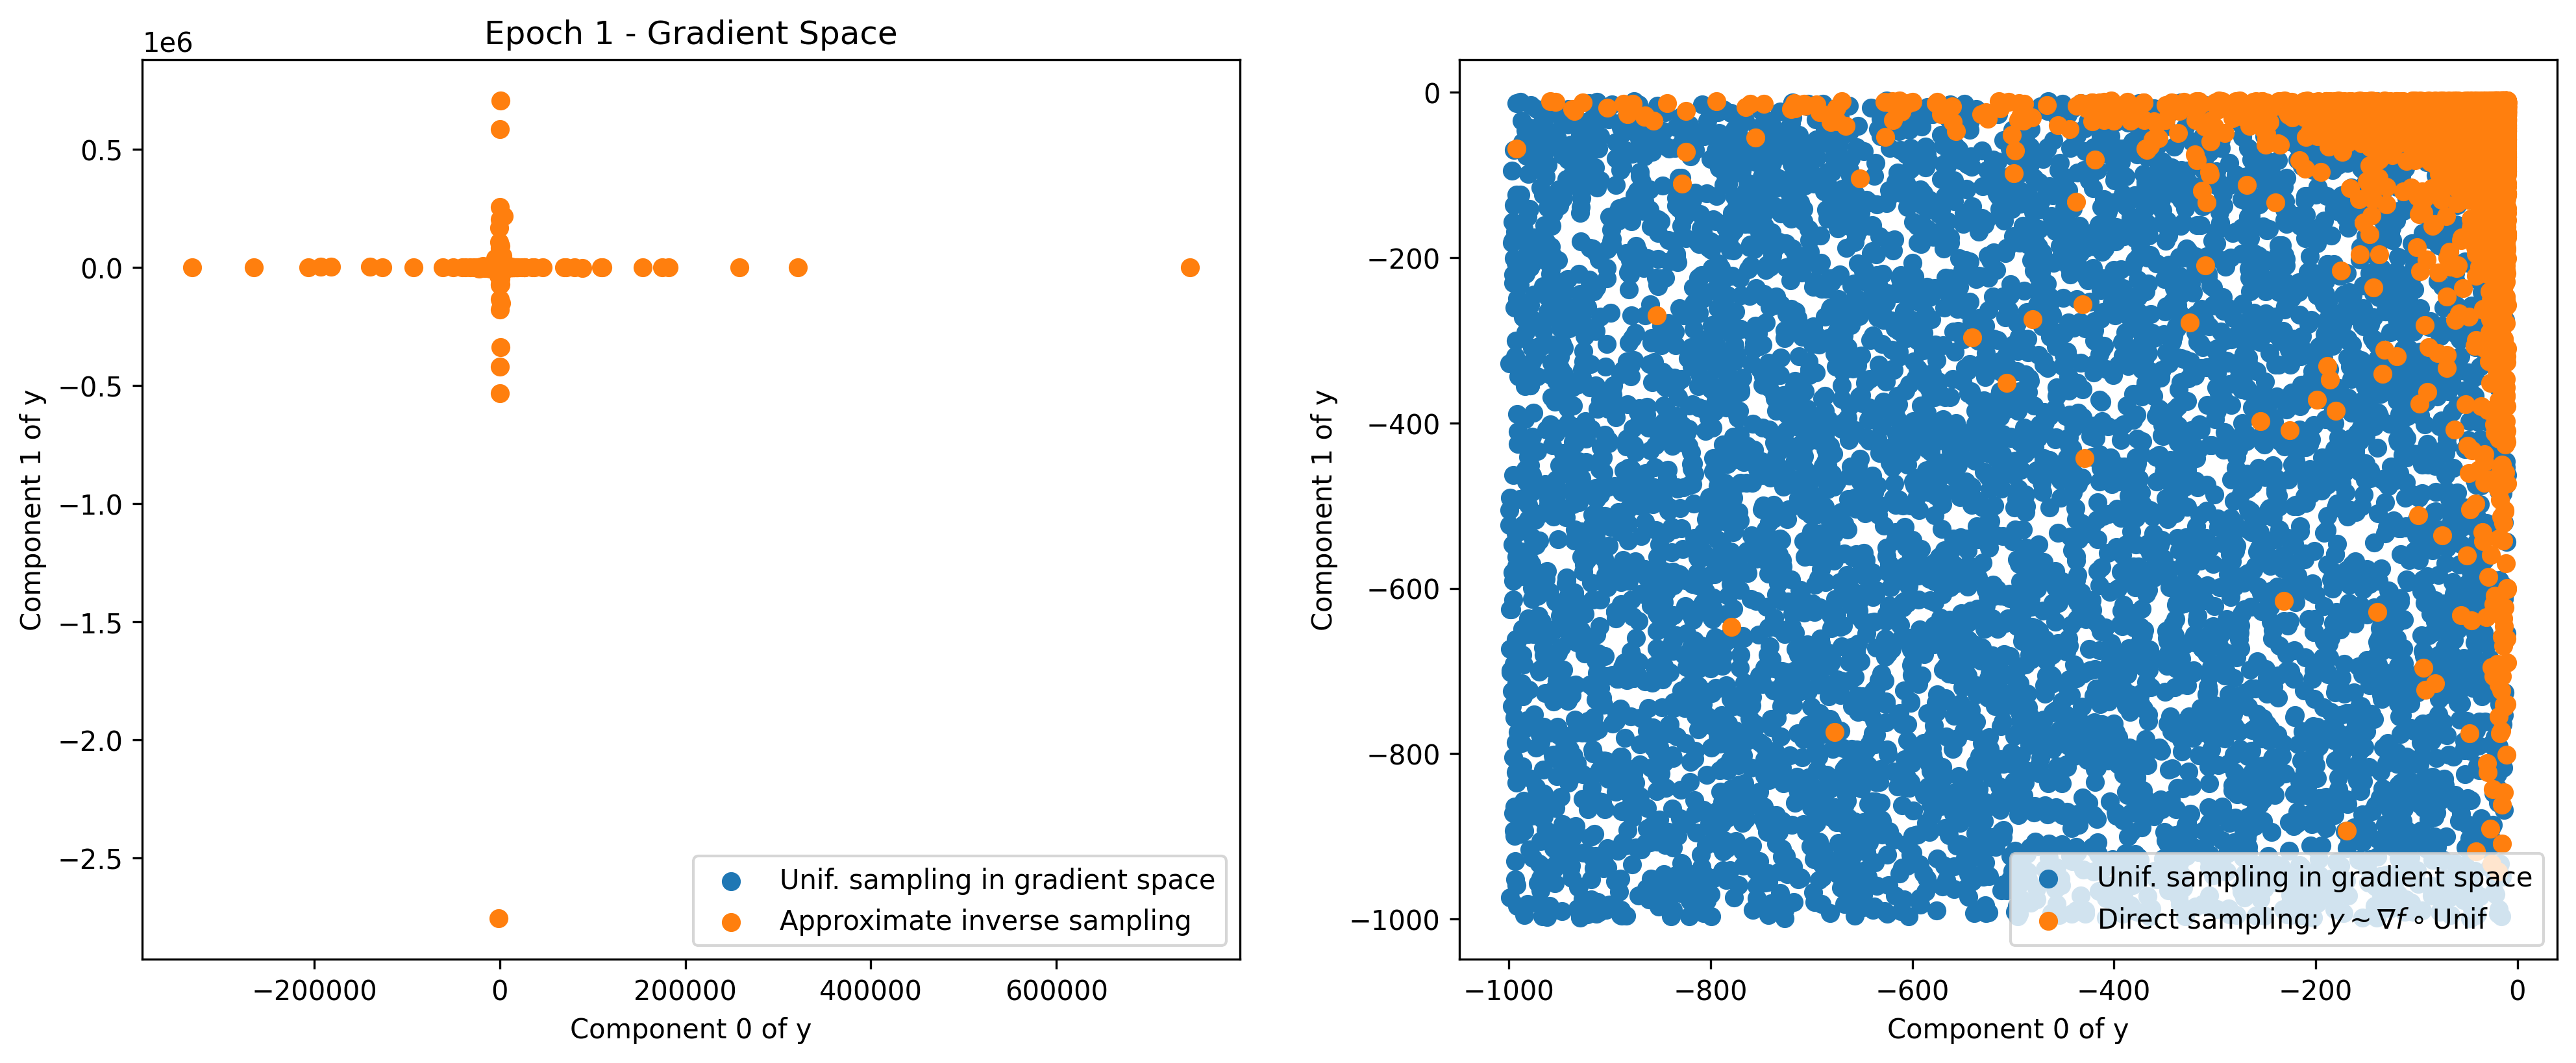

Epoch [1/20000], Total Loss: 976380.50000000, Decoder Loss: 489424.31250000, Encoder Loss: 486956.18750000, Learning Rate: 0.000010


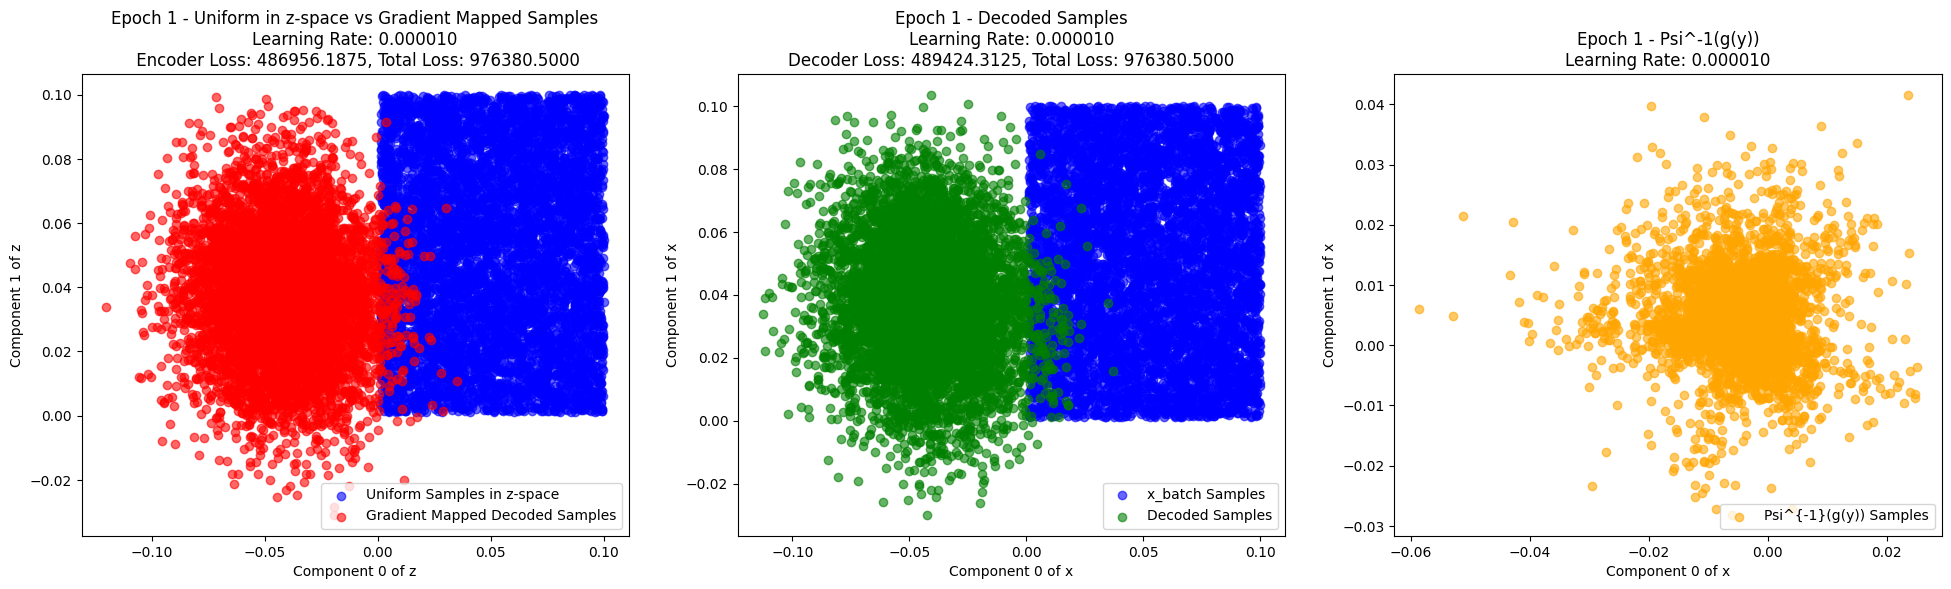

Epoch [5001/20000]


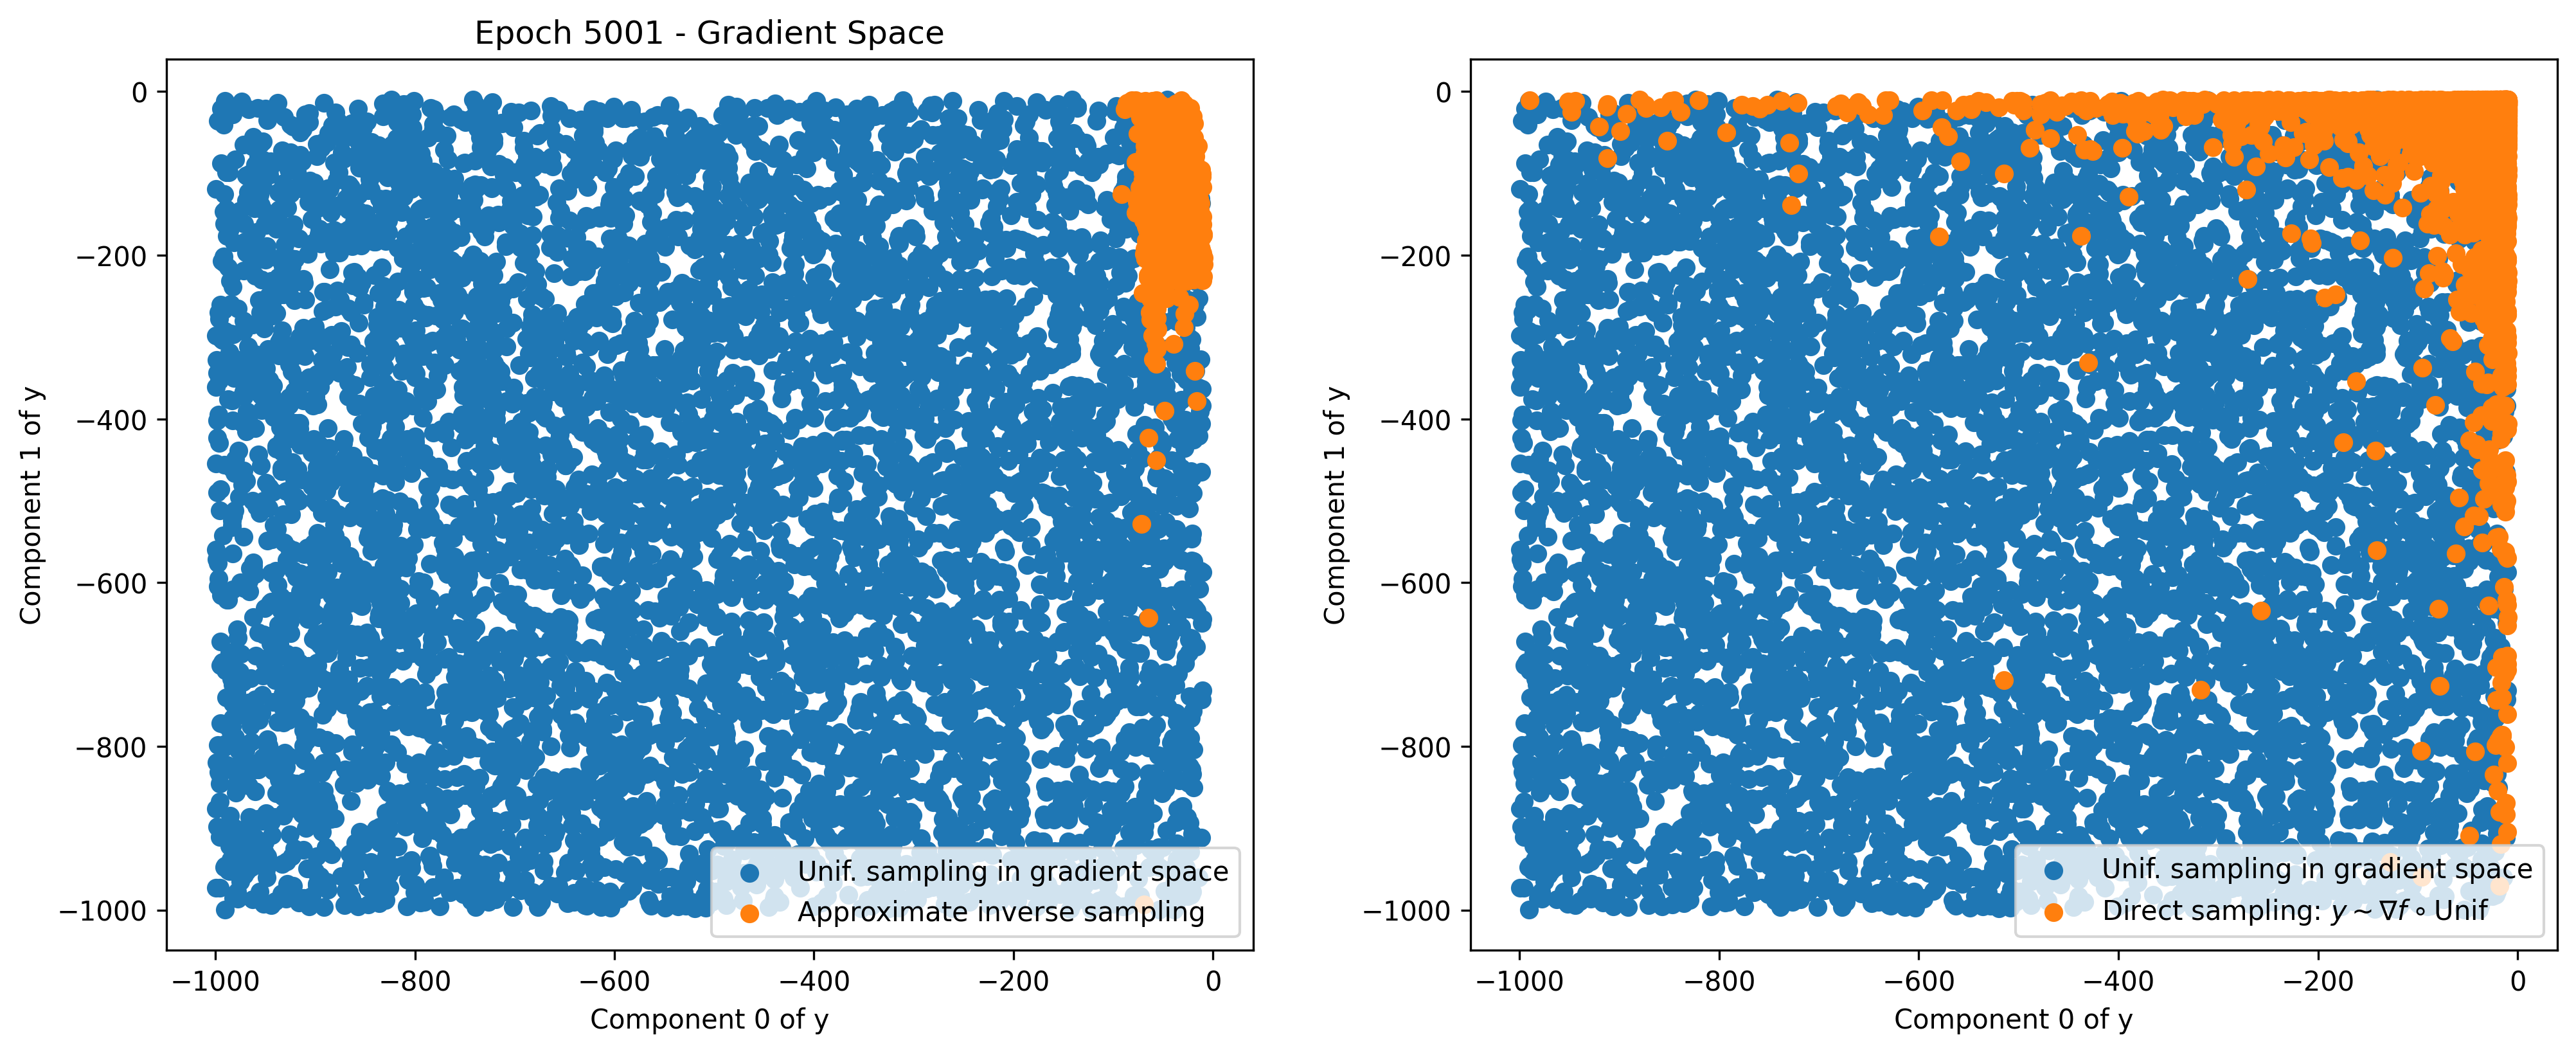

Epoch [5001/20000], Total Loss: 3303.26074219, Decoder Loss: 1652.79553223, Encoder Loss: 1650.46520996, Learning Rate: 0.000008


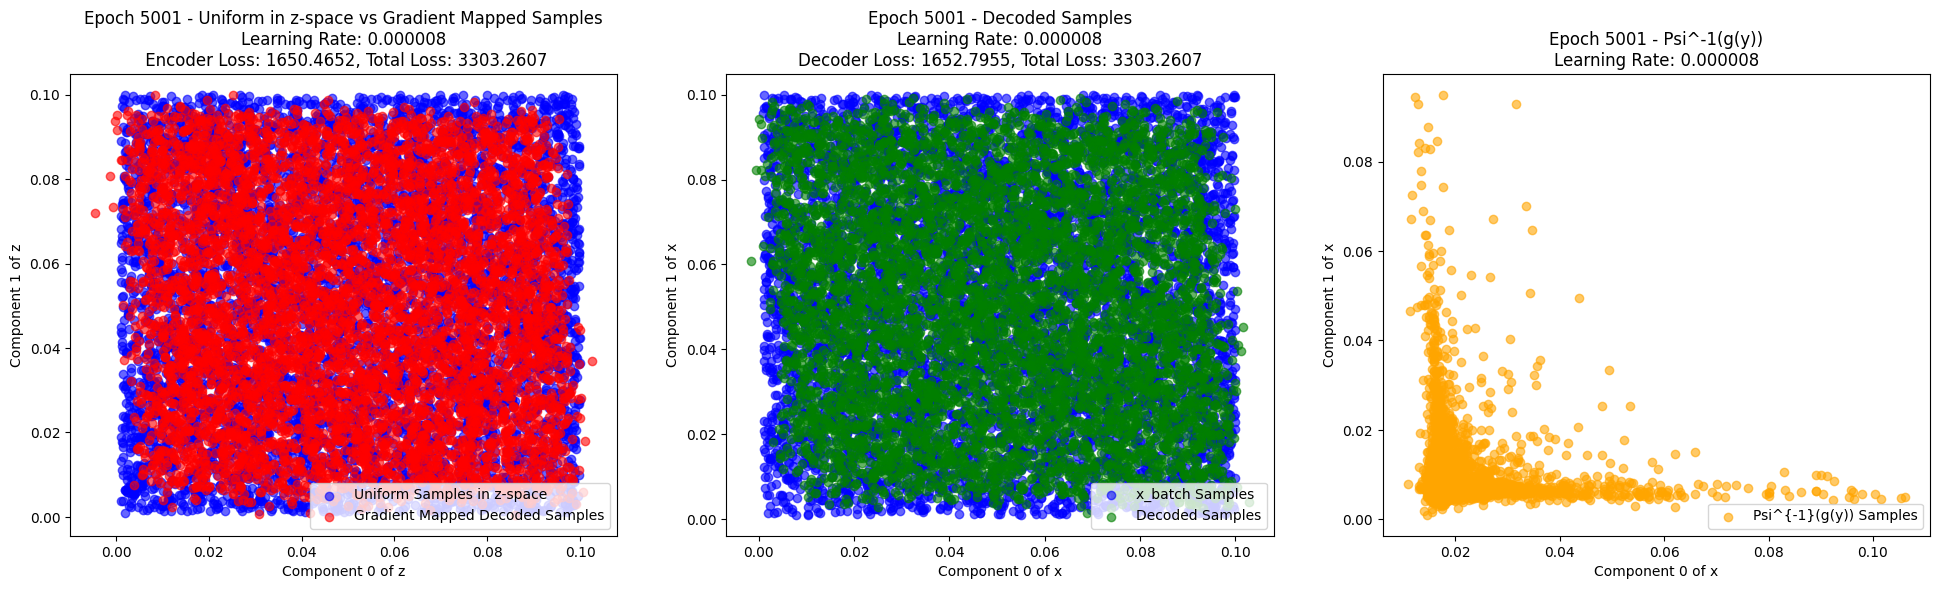

Epoch [10001/20000]


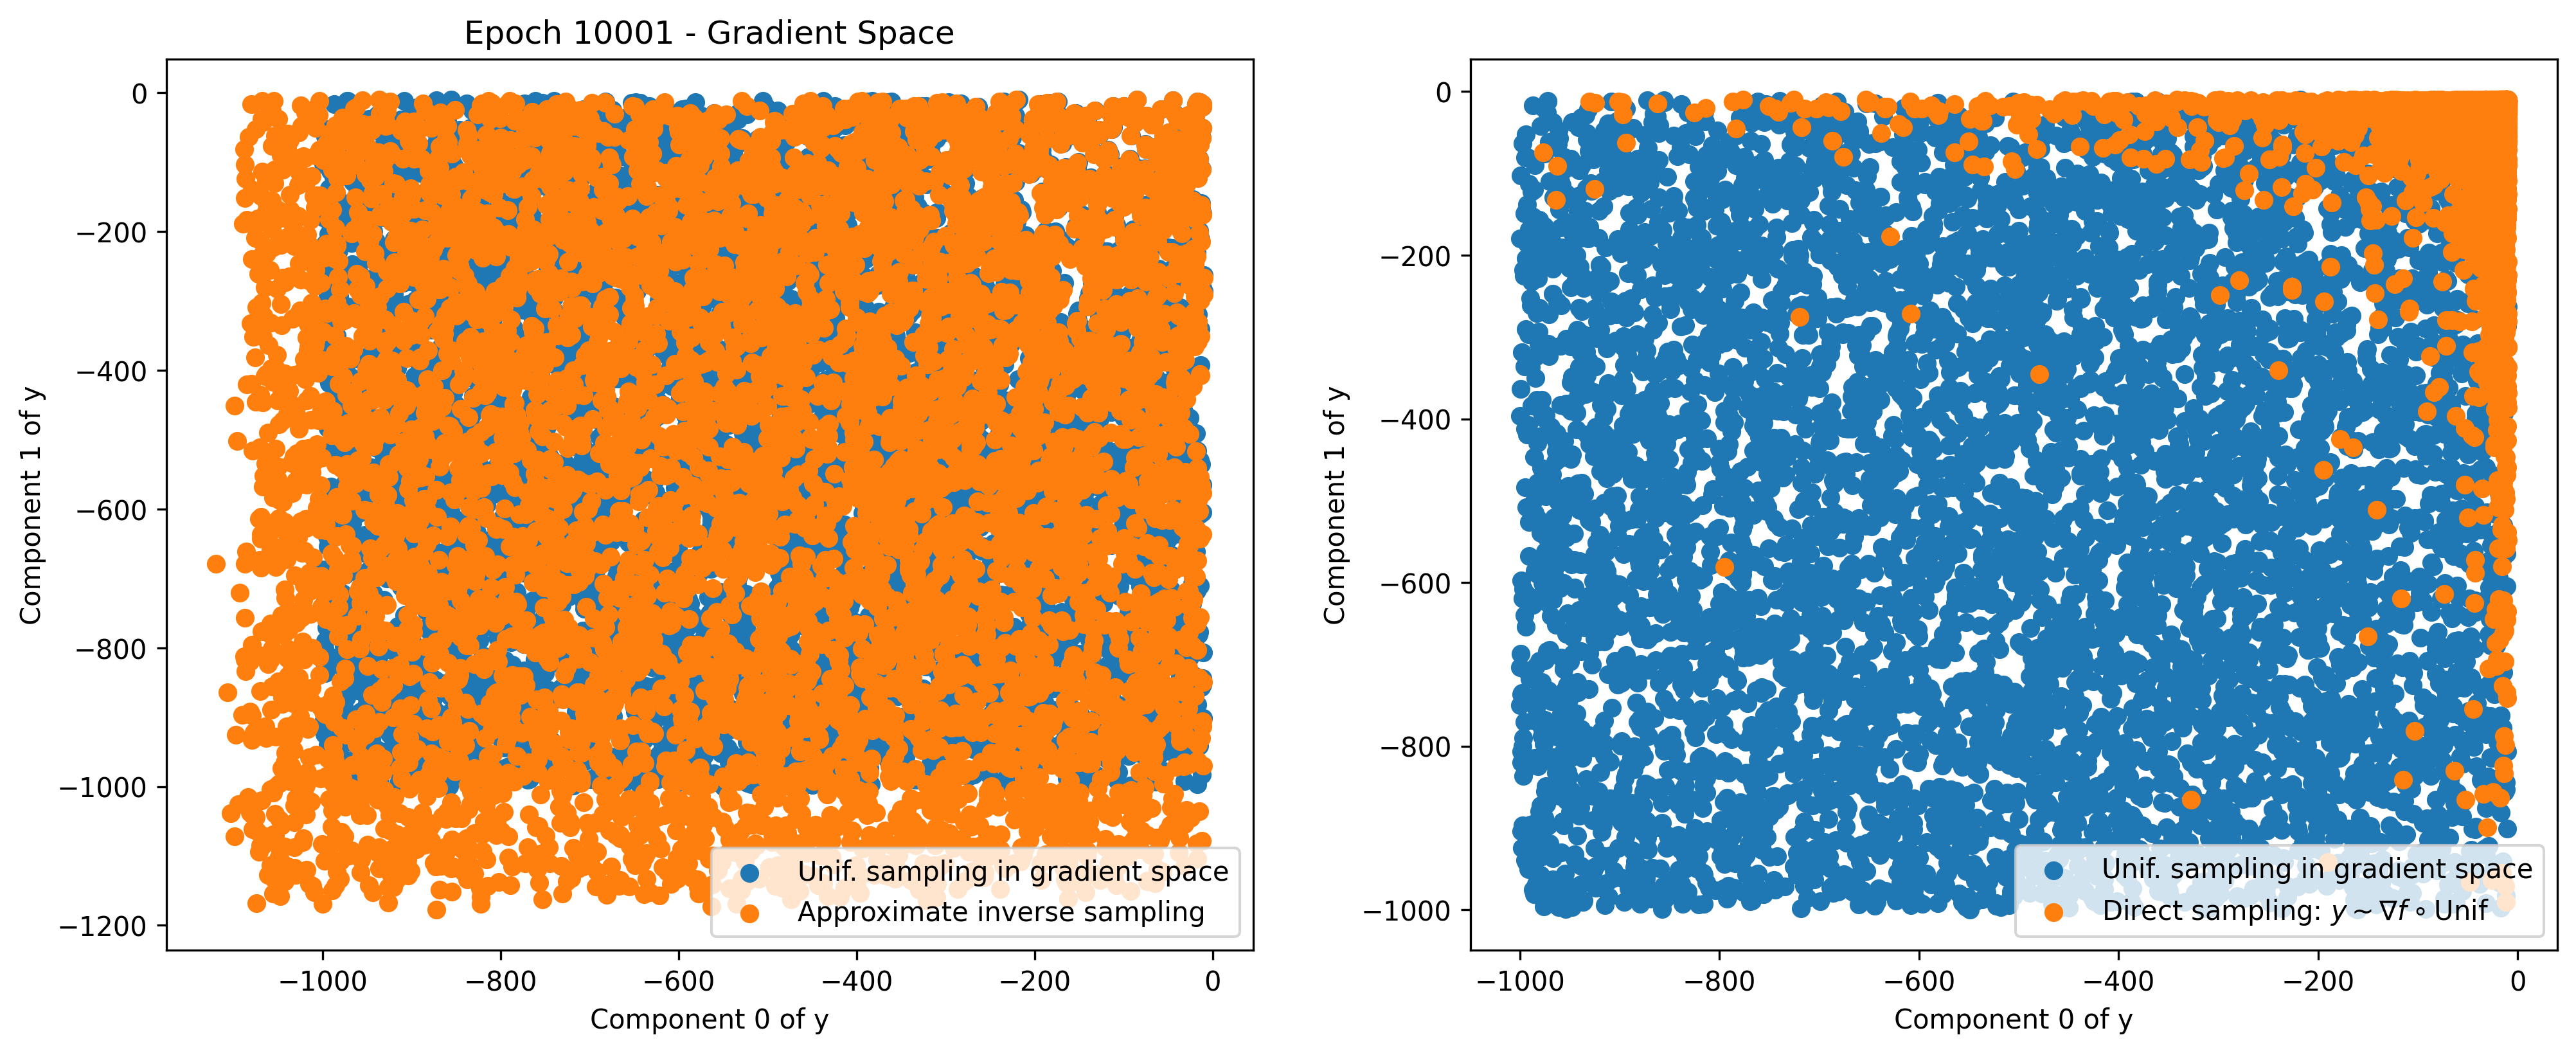

Epoch [10001/20000], Total Loss: 0.19363457, Decoder Loss: 0.09623587, Encoder Loss: 0.09739869, Learning Rate: 0.000006


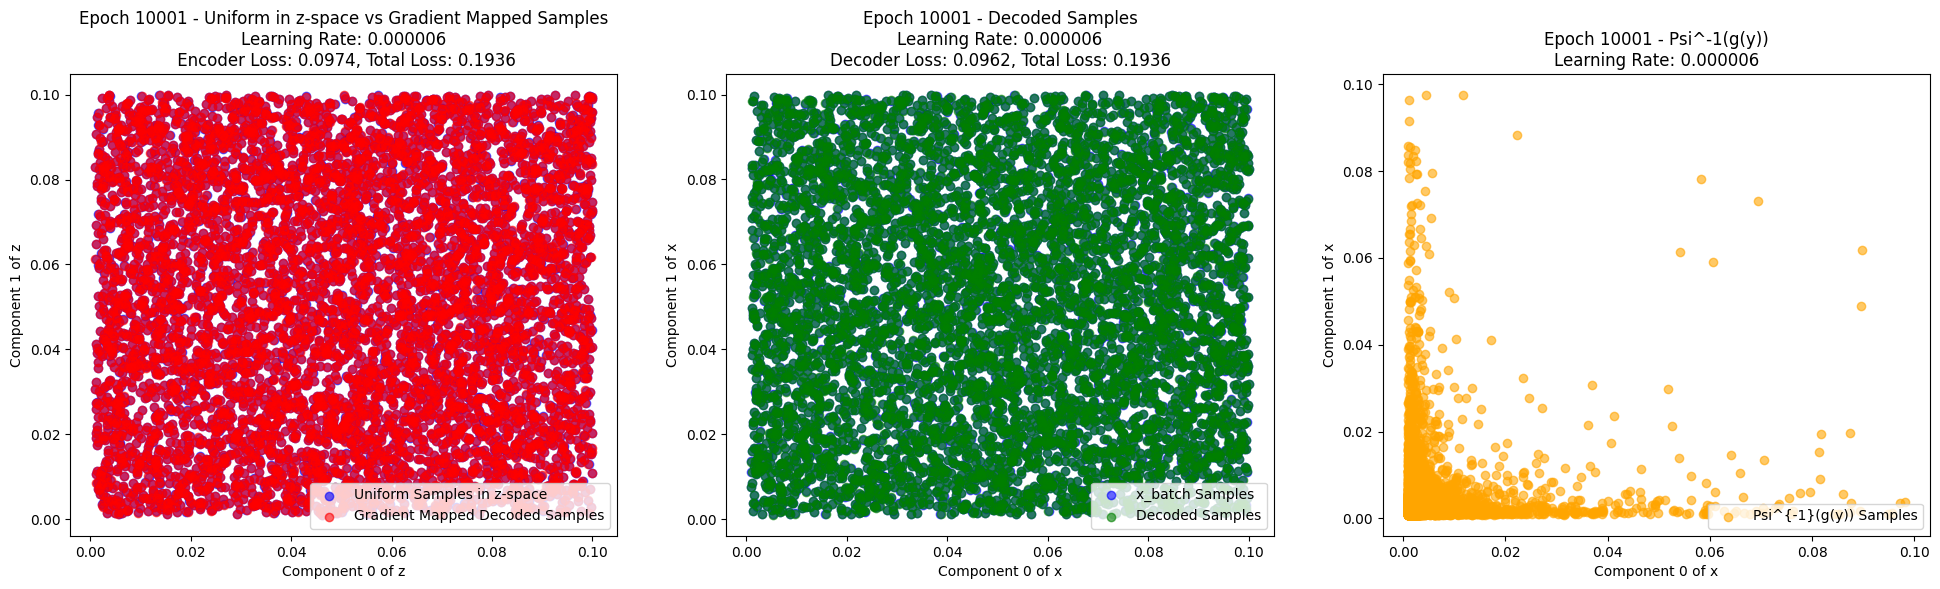

Epoch [15001/20000]


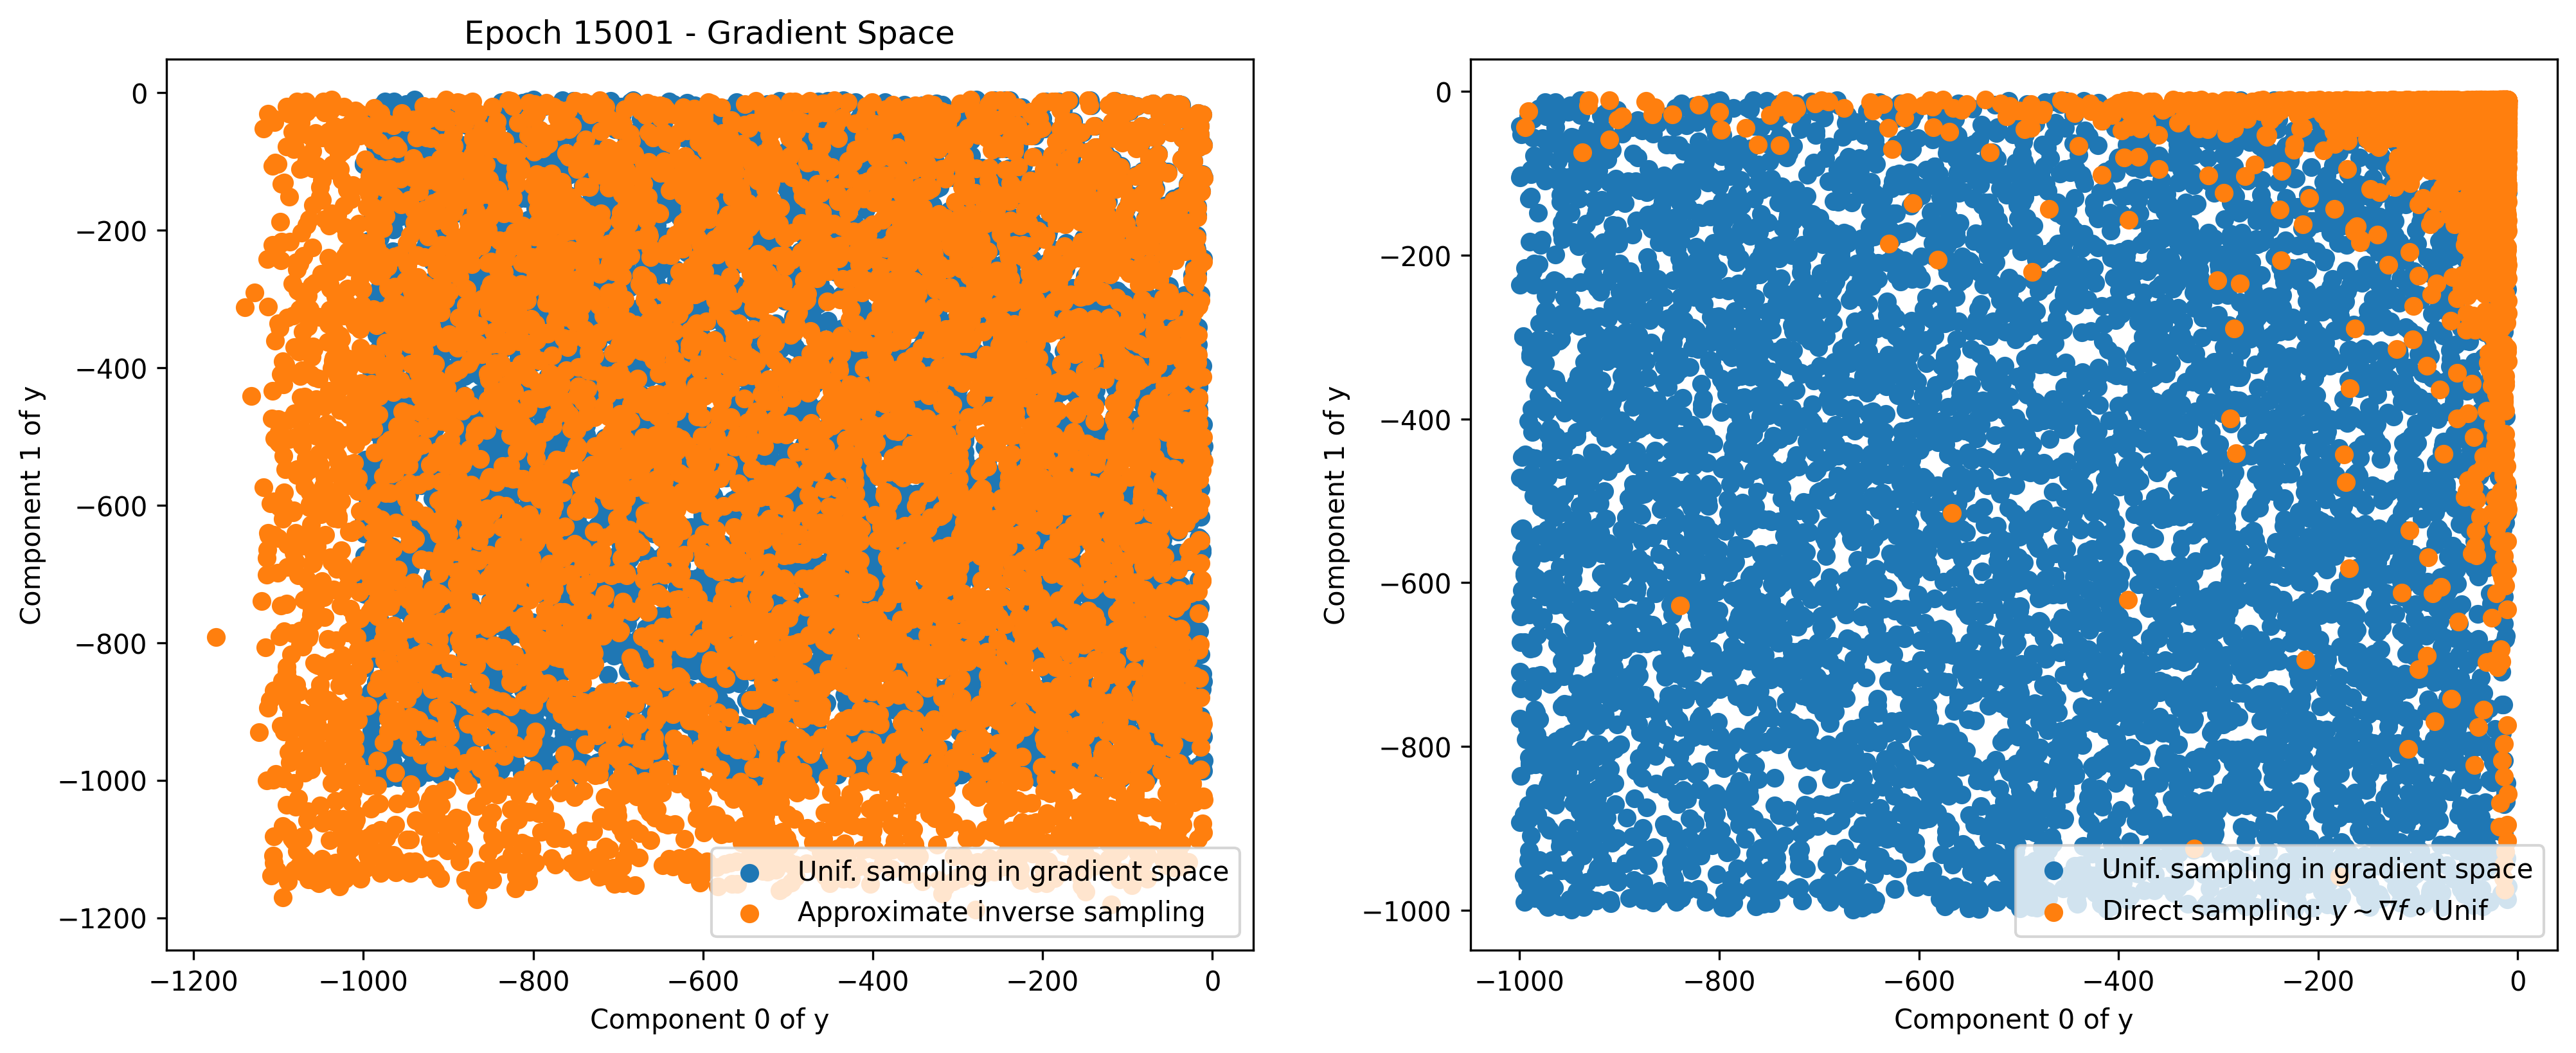

Epoch [15001/20000], Total Loss: 0.21340390, Decoder Loss: 0.10605572, Encoder Loss: 0.10734817, Learning Rate: 0.000005


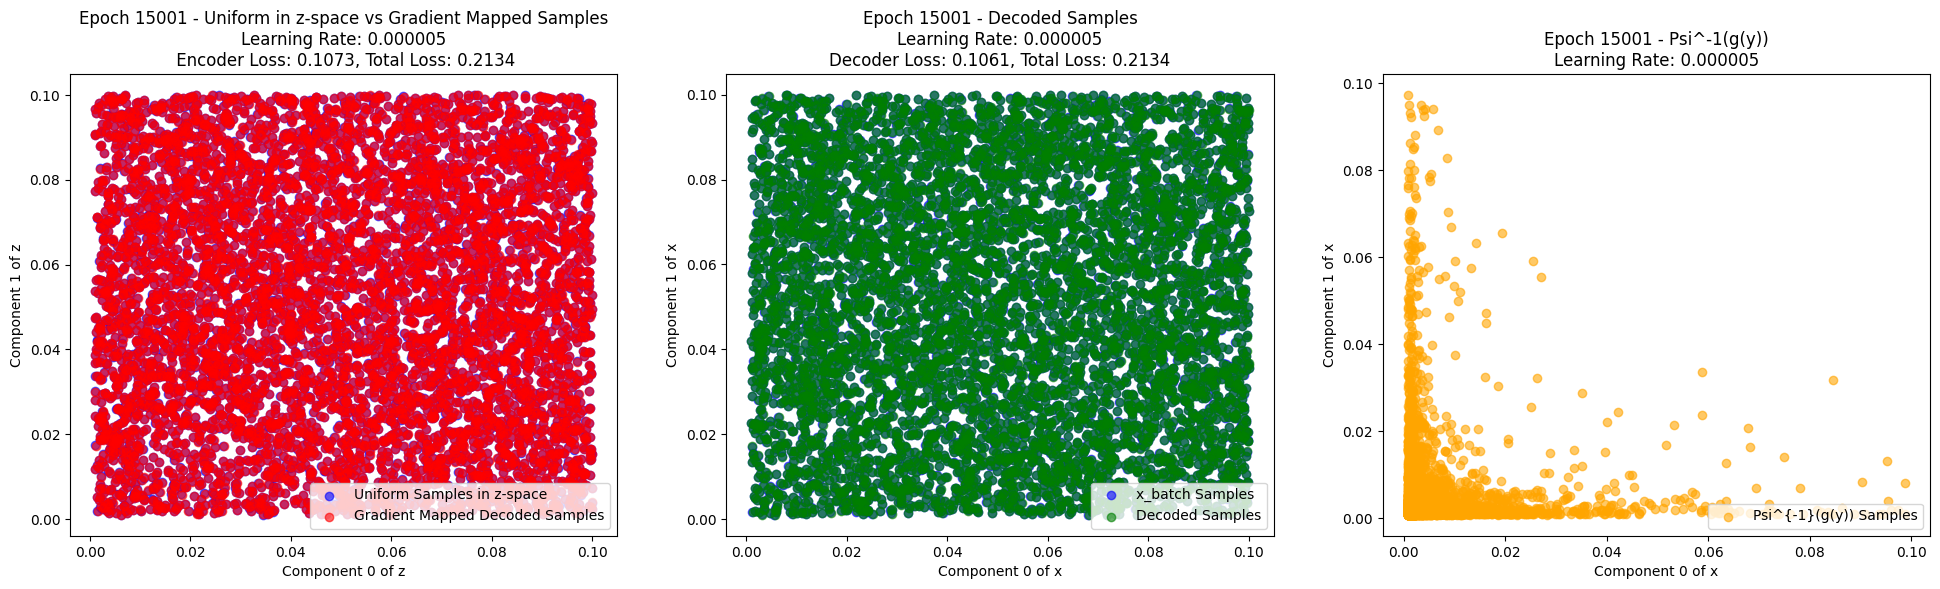

Autoencoder training runtime: 45.77 seconds
Autoencoder loss: 2.8394 


In [ ]:
from base64 import encode
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import matplotlib.pyplot as plt
import os
from flax.training import train_state
from jax import grad, vmap
from functools import partial
from jax import random
import numpy as np
import pickle
import time

# Define the autoencoder architecture
class Autoencoder(nn.Module):
    d: int  # Dimensionality

    def setup(self):
        self.fc1 = nn.Dense(128, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)
        self.fc2 = nn.Dense(128, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)
        self.fc3 = nn.Dense(self.d, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)
        self.tanh = nn.tanh

    def __call__(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

# Define gradient mapping
def h(x, f):
    return grad(f)(x)

# Define function g and operator G
def g(y):
    return -1/y

def G(x, f):
    return g(h(x, f))

# Define primal_function
primal_function = f

# Initialize the autoencoder
d = cfg.dim  # Dimensionality
key = random.PRNGKey(0)
autoencoder = Autoencoder(d=d)
x_dummy = jnp.zeros((1, d))
params = autoencoder.init(key, x_dummy)['params']

# Uniform sampling random generator
@partial(jax.jit, static_argnums=(1, 2))
def uniform_sampling_random_generator(key, batch_size, dim, minval, maxval):
    return random.uniform(key, shape=(batch_size, dim), minval=minval, maxval=maxval)

# Create the optimizer
lr_schedule = optax.exponential_decay(
    init_value=1e-5,
    transition_steps=1000,
    decay_rate=0.95,
    staircase=True
)
optimizer = optax.adam(lr_schedule)

encoder_loss_factor = 1e1/cfg.start
decoder_loss_factor = 1e1/cfg.start

# Initialize training state
ae_state = train_state.TrainState.create(
    apply_fn=autoencoder.apply,
    params=params,
    tx=optimizer
)

# Estimate y-space range
def estimate_y_space_range(key, num_samples, batch_size, dim):
    x_samples = []
    for _ in range(num_samples // batch_size):
        key, subkey = random.split(key)
        x_samples.append(uniform_sampling_random_generator(subkey, batch_size, dim, cfg.start, cfg.end))
    x_samples = jnp.concatenate(x_samples, axis=0)
    y_samples = jax.vmap(lambda xi: h(xi, primal_function))(x_samples)
    min_y = jnp.min(y_samples, axis=0)
    max_y = jnp.max(y_samples, axis=0)
    return min_y, max_y

# Estimate the range for y-space
# min_y, max_y = estimate_y_space_range(key, cfg.batch_size * 10, cfg.batch_size, d)
min_y, max_y = cfg.minval, cfg.maxval

# Loss function for training
def loss_fn(params, x, z):
    # Encode x to get encoding target
    encoding_target = jax.vmap(G, in_axes=(0, None))(x, primal_function)

    # Decode the encoding target to reconstruct x
    decoding = autoencoder.apply({'params': params}, encoding_target)

    # Calculate the decoder loss as the mean squared error between x and its reconstruction
    decoder_loss = jnp.mean(jnp.square((decoding - x)*decoder_loss_factor))

    # Decode z to get decoding target
    decoding_target = autoencoder.apply({'params': params}, z)

    # Re-encode the decoding target to reconstruct z
    reencoded = jax.vmap(G, in_axes=(0, None))(decoding_target, primal_function)

    # Create a mask to filter out non-finite values in reencoded and z
    finite_mask = jnp.logical_and(jnp.isfinite(reencoded).all(axis=1), jnp.isfinite(z).all(axis=1))

    # Apply the mask to reencoded and z
    reencoded = jnp.where(finite_mask[:, None], reencoded, jnp.zeros_like(reencoded))
    z = jnp.where(finite_mask[:, None], z, jnp.zeros_like(z))

    # Calculate the encoder loss as the mean squared error between z and its reconstruction
    encoder_loss = jnp.mean(jnp.square((reencoded - z)*encoder_loss_factor)) if reencoded.size > 0 else 0.0

    # Return individual losses and their sum
    return decoder_loss, encoder_loss, (decoder_loss + encoder_loss)

# Gradient function
@jax.jit
def train_step(ae_state, x, z):
    def loss(params):
        return loss_fn(params, x, z)[2]
    grads = grad(loss)(ae_state.params)
    return ae_state.apply_gradients(grads=grads)

# Save model function
def save_model(ae_state, path):
    with open(path, 'wb') as f:
        pickle.dump(ae_state.params, f)

# Load model function
def load_model(path, ae_state):
    with open(path, 'rb') as f:
        params = pickle.load(f)
    ae_state = ae_state.replace(params=params)
    return ae_state

# Psi^-1 generator
@partial(jax.jit, static_argnums=(1, 2, 3, 4))
def psi_inv_generator(key, batch_size, dim, minval, maxval):
    y_samples = uniform_sampling_random_generator(key, batch_size, dim, minval, maxval)
    z_samples = g(y_samples)
    return autoencoder.apply({'params': params}, z_samples)

# Plotting function to observe the progress
def plot_progress(uniform_samples_z, gradient_mapped_encoded_samples, x_batch, encoded_samples_x, decoded_samples_x, Psi_inv_samples, epoch, current_lr, decoder_loss, encoder_loss, total_loss, z_samples, save_fig=True):
    if d >= 2:
        fig, axes = plt.subplots(1, 3, figsize=(24, 6), dpi=DPI)

        # Plot 1: Uniform in z-space vs Gradient Mapped Samples
        axes[0].scatter(uniform_samples_z[:, 0], uniform_samples_z[:, 1], color='blue', alpha=0.6, label='Uniform Samples in z-space')
        axes[0].scatter(gradient_mapped_encoded_samples[:, 0], gradient_mapped_encoded_samples[:, 1], color='red', alpha=0.6, label='Gradient Mapped Decoded Samples')
        axes[0].set_xlabel('Component 0 of z')
        axes[0].set_ylabel('Component 1 of z')
        axes[0].set_title(f'Epoch {epoch+1} - Uniform in z-space vs Gradient Mapped Samples\nLearning Rate: {current_lr:.6f}\n Encoder Loss: {encoder_loss:.4f}, Total Loss: {total_loss:.4f}')
        axes[0].legend(loc='lower right')

        # Plot 2: Decoded Samples and x_batch
        axes[1].scatter(x_batch[:, 0], x_batch[:, 1], color='blue', alpha=0.6, label='x_batch Samples')
        axes[1].scatter(decoded_samples_x[:, 0], decoded_samples_x[:, 1], color='green', alpha=0.6, label='Decoded Samples')
        axes[1].set_xlabel('Component 0 of x')
        axes[1].set_ylabel('Component 1 of x')
        axes[1].set_title(f'Epoch {epoch+1} - Decoded Samples\nLearning Rate: {current_lr:.6f}\nDecoder Loss: {decoder_loss:.4f}, Total Loss: {total_loss:.4f}')
        axes[1].legend(loc='lower right')

        # Plot 3: Psi^-1(g(y))
        if z_samples is not None:
            axes[2].scatter(Psi_inv_samples[:, 0], Psi_inv_samples[:, 1], color='orange', alpha=0.6, label='Psi^{-1}(g(y)) Samples')
        axes[2].set_xlabel('Component 0 of x')
        axes[2].set_ylabel('Component 1 of x')
        axes[2].set_title(f'Epoch {epoch+1} - Psi^{-1}(g(y))\nLearning Rate: {current_lr:.6f}')
        axes[2].legend(loc='lower right')

        if save_fig:
            plt.savefig(f'/content/plots/epoch_{epoch+1}.png')
        plt.show()

import matplotlib.pyplot as plt
import numpy as np

def plot_gradient_space(image_under_grad_f_of_Psi_inv_samples, y_batch, h_x_batch, epoch, save_fig=False):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6), dpi=300)
    ax[0].scatter(y_batch[:,0], y_batch[:,1], label='Unif. sampling in gradient space')
    ax[0].scatter(image_under_grad_f_of_Psi_inv_samples[:,0], image_under_grad_f_of_Psi_inv_samples[:,1], label='Approximate inverse sampling')

    ax[0].set_xlabel('Component 0 of y')
    ax[0].set_ylabel('Component 1 of y')
    ax[0].set_title(f'Epoch {epoch+1} - Gradient Space')
    ax[0].legend(loc='lower right')

    ax[1].scatter(y_batch[:,0], y_batch[:,1], label='Unif. sampling in gradient space' )
    ax[1].scatter(h_x_batch[:,0], h_x_batch[:,1], label=r'Direct sampling: $y \sim \nabla f \circ \mathrm{Unif}$')

    ax[1].set_xlabel('Component 0 of y')
    ax[1].set_ylabel('Component 1 of y')
    ax[1].legend(loc='lower right')

    if save_fig:
        plt.savefig(f'/content/plots/gradient_space_epoch_{epoch+1}.png')

    plt.show()



# Training function
def train_autoencoder(ae_state, key, num_epochs, batch_size, start_epoch=0):
    for epoch in range(start_epoch, start_epoch + num_epochs):

        key, subkey = random.split(key)
        x_batch = uniform_sampling_random_generator(subkey, batch_size, d, cfg.start, cfg.end)

        key, subkey = random.split(key)
        y_batch = uniform_sampling_random_generator(subkey, batch_size, d, min_y, max_y)
        a = jnp.minimum(g(min_y), g(max_y))
        b = jnp.maximum(g(min_y), g(max_y))
        z_batch = uniform_sampling_random_generator(subkey, batch_size, d, a, b)

        ae_state = train_step(ae_state, x_batch, z_batch)

        if epoch == start_epoch + num_epochs - 1:
            save_model(ae_state, f'/content/model_weights/{cfg.f_func}_autoencoder_epoch_{epoch+1}.pkl')

        if epoch % 5000 == 0:
            print("=========================================")
            print(f"Epoch [{epoch + 1}/{start_epoch + num_epochs}]")
            print("=========================================")
            z_samples = jax.vmap(G, in_axes=(0, None))(x_batch, primal_function)
            decoded_samples_x = autoencoder.apply({'params': ae_state.params}, z_samples)
            encoded_samples_x = autoencoder.apply({'params': ae_state.params}, z_batch)
            Psi_inv_samples = autoencoder.apply({'params': ae_state.params}, g(y_batch))

            image_under_grad_f_of_Psi_inv_samples = jax.vmap(h, in_axes=(0, None))(Psi_inv_samples, primal_function)

            h_x_batch = jax.vmap(h, in_axes=(0, None))(x_batch, primal_function)

            plot_gradient_space(image_under_grad_f_of_Psi_inv_samples, y_batch, h_x_batch , epoch, save_fig=False)

            gradient_mapped_encoded_samples = jax.vmap(G, in_axes=(0, None))(encoded_samples_x, primal_function)

            decoder_loss, encoder_loss, total_loss = loss_fn(ae_state.params, x_batch, z_batch)
            current_lr = lr_schedule(epoch)
            print(f"Epoch [{epoch + 1}/{start_epoch + num_epochs}], Total Loss: {total_loss:.8f}, Decoder Loss: {decoder_loss:.8f}, Encoder Loss: {encoder_loss:.8f}, Learning Rate: {current_lr:.6f}")

            plot_progress(z_batch, gradient_mapped_encoded_samples, x_batch, encoded_samples_x, decoded_samples_x, Psi_inv_samples, epoch, current_lr, decoder_loss, encoder_loss, total_loss, z_samples)

            # ae_loss = total_loss
            normalization_coef = (max_y - min_y)*jnp.sqrt(d)/2
            ae_loss = (jnp.mean(jnp.square(image_under_grad_f_of_Psi_inv_samples - y_batch)))/normalization_coef # ae_loss for the right inverse; normalization to make it compaprable with left inverse, due to diffferent domains

    return ae_state, ae_loss

# Create the directory to save model weights if it does not exist
model_weights_path = '/content/model_weights'
os.makedirs(model_weights_path, exist_ok=True)

# Optionally create directory to save plots
plots_path = '/content/plots'
os.makedirs(plots_path, exist_ok=True)

# Calculate runtime
start_time = time.time()

# Train the autoencoder
num_epochs_total = 20000  # cfg.num_epochs
ae_state, ae_loss = train_autoencoder(ae_state, key, num_epochs_total, cfg.batch_size)

end_time = time.time()
ae_runtime = end_time - start_time

print(f"Autoencoder training runtime: {ae_runtime:.2f} seconds")
print(f"Autoencoder loss: {ae_loss:.4f} ")


In [ ]:
# Define the function to apply the encoder
def apply_encoder(params, inputs):
    return  autoencoder.apply({'params': ae_state.params}, g(inputs)) #autoencoder.apply({'params': params}, inputs)

# Generate y_samples uniformly
def generate_y_samples_uniformly(key, batch_size, dim, minval, maxval):
    return random.uniform(key, shape=(batch_size, dim), minval=minval, maxval=maxval)

# Placeholder for psi function
def psi(x):
    return grad(primal_function)(x)


# Small sample exercise
sample_size = 1
y_samples = generate_y_samples_uniformly(random.PRNGKey(25), sample_size, cfg.dim, cfg.minval, cfg.maxval)
x_samples = apply_encoder(ae_state.params, y_samples)
y_reconstructed = jax.vmap(h, in_axes=(0, None))(x_samples, primal_function) #jax.vmap(psi, in_axes=(0,))(x_samples)
print("y-sample       x-sample       y-reconstructed")
for y, x, y_rec in zip(y_samples, x_samples, y_reconstructed):
    print(f"{y} -> {x} -> {y_rec}")



y-sample       x-sample       y-reconstructed
[-112.02258  -465.31708  -502.71036  -396.18982  -719.7612   -385.034
 -435.00494   -56.908752 -961.2462   -814.82605  -475.36365  -858.83813
  -25.366333 -172.3822   -276.4662   -384.24835   -52.549927 -689.5607
 -589.9418   -395.25342 ] -> [0.00885878 0.00206304 0.00185989 0.00241993 0.00118837 0.00245963
 0.00218461 0.01745566 0.00090468 0.00106049 0.00203312 0.00099573
 0.03938407 0.00570608 0.00345471 0.00249237 0.01888464 0.00126152
 0.00162528 0.00245585] -> [ -112.882416  -484.72128   -537.666     -413.23547   -841.48865
  -406.56555   -457.7476     -57.288    -1105.3628    -942.9577
  -491.8541   -1004.29205    -25.390978  -175.25154   -289.45993
  -401.22446    -52.953075  -792.69354   -615.2774    -407.1914  ]


In [ ]:
encoder_params = ae_state.params

# After training, perform the small sample exercise to verify the encoder's generalization
sample_size = 2
y_samples = generate_y_samples_uniformly(key, sample_size, cfg.dim, cfg.minval, cfg.maxval)

# Apply encoder to y-samples to get x-samples
x_samples = apply_encoder(encoder_params, y_samples)

# Apply gradient mapping to x-samples to get y-reconstructed
y_reconstructed = jax.vmap(psi, in_axes=(0,))(x_samples)

# Print the results after training
print("After Training:")
print("y-sample       x-sample       y-reconstructed")
for y, x, y_rec in zip(y_samples, x_samples, y_reconstructed):
    print(f"{y} -> {x} -> {y_rec}")

After Training:
y-sample       x-sample       y-reconstructed
[-481.69196  -963.56104  -118.648254 -329.8495   -412.83673  -224.48907
 -871.02563  -236.83612  -298.36737  -930.3503   -617.0645   -902.24164
 -513.6544    -58.890503 -654.6869    -20.980896 -621.8239   -791.0404
 -779.0646   -441.60187 ] -> [0.00198866 0.00090057 0.0082679  0.00289564 0.00220178 0.00429952
 0.00102    0.00403211 0.00320572 0.00087738 0.00155989 0.00091509
 0.00181517 0.01695283 0.00138848 0.04766287 0.00141728 0.00102592
 0.00120957 0.00216188] -> [ -502.85117  -1110.4087    -120.94975   -345.3466    -454.17776
  -232.58435   -980.3882    -248.00888   -311.9421   -1139.7596
  -641.07025  -1092.7897    -550.91125    -58.98719   -720.2131
   -20.980692  -705.5752    -974.7311    -826.74274   -462.56094 ]
[-450.71844  -374.35553  -652.5235   -461.04248  -808.4929   -694.3306
 -748.7381   -380.86658  -614.7008   -391.50403  -210.66992  -129.73743
  -39.676514  -27.963501 -156.77576  -763.6905   -932.5815   -7

In [ ]:
import jax
import jax.numpy as jnp

def x_uniform_sampling_generator(cfg, key, minval_x=None, maxval_x=None):
    minval_x = minval_x if minval_x is not None else cfg.start
    maxval_x = maxval_x if maxval_x is not None else cfg.end
    while True:
        key, subkey = jax.random.split(key)
        U = jax.random.uniform(key=subkey, shape=(cfg.batch_size, cfg.dim), minval=minval_x, maxval=maxval_x)
        yield U

def y_uniform_sampling_generator(cfg, key, minval_y=None, maxval_y=None):
    minval_y = minval_y if minval_y is not None else cfg.minval
    maxval_y = maxval_y if maxval_y is not None else cfg.maxval
    while True:
        key, subkey = jax.random.split(key)
        U = jax.random.uniform(key=subkey, shape=(cfg.batch_size, cfg.dim), minval=minval_y, maxval=maxval_y)
        yield U

def create_inverse_uniform_sampling_random_generator(cfg, key, minval, maxval,encoder_params, encoder):
    while True:
        batch_fulfilled = False
        while not batch_fulfilled:
            key, subkey = jax.random.split(key)
            y_samples = generate_y_samples_uniformly(subkey, cfg.batch_size, cfg.dim, minval, maxval)
            x_samples = apply_encoder(encoder_params, y_samples) #encoder({'params': params}, y_samples)
            yield x_samples
            batch_fulfilled = True
            # if cfg.start is not None and cfg.end is not None:
            #     is_within_domain = jnp.logical_and(x_samples >= cfg.start, x_samples <= cfg.end).all(axis=-1)
            #     filtered_samples = x_samples[is_within_domain]
            # else:
            #     filtered_samples = x_samples

            # if filtered_samples.size > 0:
            #     yield filtered_samples
            #     batch_fulfilled = True

# Replace the following placeholder functions with your actual implementations
def generate_y_samples_uniformly(key, batch_size, dim, minval = cfg.minval, maxval = cfg.maxval):
    return jax.random.uniform(key, shape=(batch_size, dim), minval=minval, maxval=maxval)


def descriptive_statistics(x_samples, name="Data"):
    # Compute and return statistics
    return {
        'min': jnp.min(x_samples, axis=0),
        'max': jnp.max(x_samples, axis=0),
        'mean': jnp.mean(x_samples, axis=0),
        'std': jnp.std(x_samples, axis=0)
    }

# Initialize parameters and generators
encoder_params = ae_state.params
x_inverse_sampling = create_inverse_uniform_sampling_random_generator(cfg, key, cfg.minval, cfg.maxval, encoder_params, apply_encoder)

# # Generate y-samples uniformly for testing
# y_samples = generate_y_samples_uniformly(key, cfg.batch_size, cfg.dim, cfg.minval, cfg.maxval)

# # Apply encoder to y-samples to get x-samples
# x1 = apply_encoder(encoder_params, y_samples)

# # Compute and display descriptive statistics for the generated data
# stat = descriptive_statistics(x1, name="Inverse Sampling Data")

# start_x = jnp.min(stat['min'])
# end_x = jnp.max(stat['max'])

# Initialize the uniform sampling generator
# uniform_x_generator = generate_x_samples_uniformly(cfg, key)
x_uniform_sampling =x_uniform_sampling_generator(cfg, key, minval_x= cfg.start, maxval_x=cfg.end) #  generate_x_samples_uniformly(cfg, key, minval_x=cfg.start, maxval_x=cfg.end)
y_uniform_sampling = y_uniform_sampling_generator(cfg, key, minval_y= cfg.minval, maxval_y=cfg.maxval)

minval = cfg.minval  # = minval_y
maxval = cfg.maxval  # = maxval_y


In [ ]:
%time x1 = next(x_inverse_sampling)
%time x2 = next(x_uniform_sampling )

descriptive_statistics(x1, name="Inverse Sampling Data")
descriptive_statistics(x2, name="Uniform Sampling Data")



CPU times: user 51.5 ms, sys: 966 µs, total: 52.4 ms
Wall time: 48.3 ms
CPU times: user 32.4 ms, sys: 3.02 ms, total: 35.4 ms
Wall time: 32.9 ms


{'min': Array([0.00100782, 0.00106098, 0.00103492, 0.00100407, 0.00102619,
        0.00100788, 0.00100209, 0.00100709, 0.0010231 , 0.00100559,
        0.00101355, 0.00100078, 0.00101456, 0.00101659, 0.00102937,
        0.00105176, 0.00100006, 0.00101401, 0.00101604, 0.00100152],      dtype=float32),
 'max': Array([0.09998234, 0.09999962, 0.09999731, 0.0999996 , 0.09999575,
        0.09999954, 0.09998652, 0.09997211, 0.09998899, 0.09994431,
        0.0999745 , 0.09999851, 0.09999312, 0.09999434, 0.09999402,
        0.09997806, 0.09999719, 0.099999  , 0.09997871, 0.09998323],      dtype=float32),
 'mean': Array([0.05109962, 0.05015499, 0.05044549, 0.05042858, 0.05033435,
        0.05011032, 0.05100107, 0.05106991, 0.0506118 , 0.05116188,
        0.05068834, 0.05006446, 0.05066041, 0.05075353, 0.05114391,
        0.05001796, 0.05012403, 0.05041402, 0.0508636 , 0.05039351],      dtype=float32),
 'std': Array([0.02851095, 0.02860385, 0.0285221 , 0.0288184 , 0.02853914,
        0.02872529, 0

In [ ]:
# key, subkey = jax.random.split(key)
# y_samples = generate_y_samples_uniformly(subkey, cfg.batch_size, cfg.dim, minval, maxval)
# x_samples = apply_encoder({'params': params}, y_samples)

# is_within_domain = jnp.logical_and(x_samples >= cfg.start, x_samples <= cfg.end).all(axis=-1)


In [ ]:
# x1, x2, x1.shape
# next(x_inverse_sampling)
# x_samples, is_within_domain ,  cfg.start, cfg.end

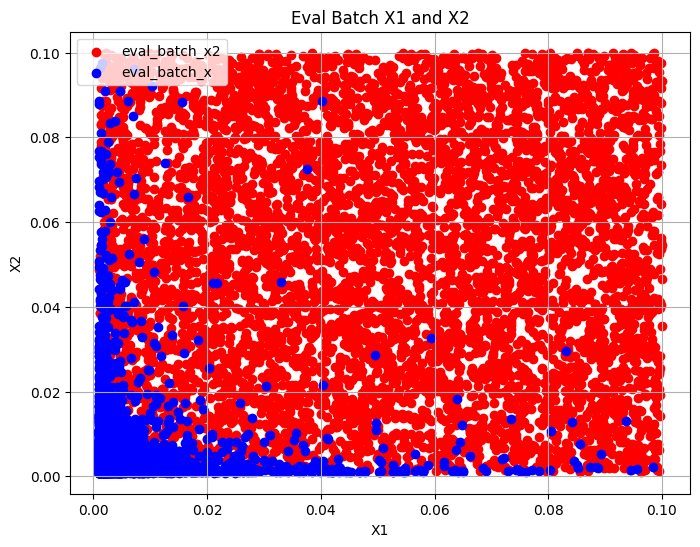

1167.8478


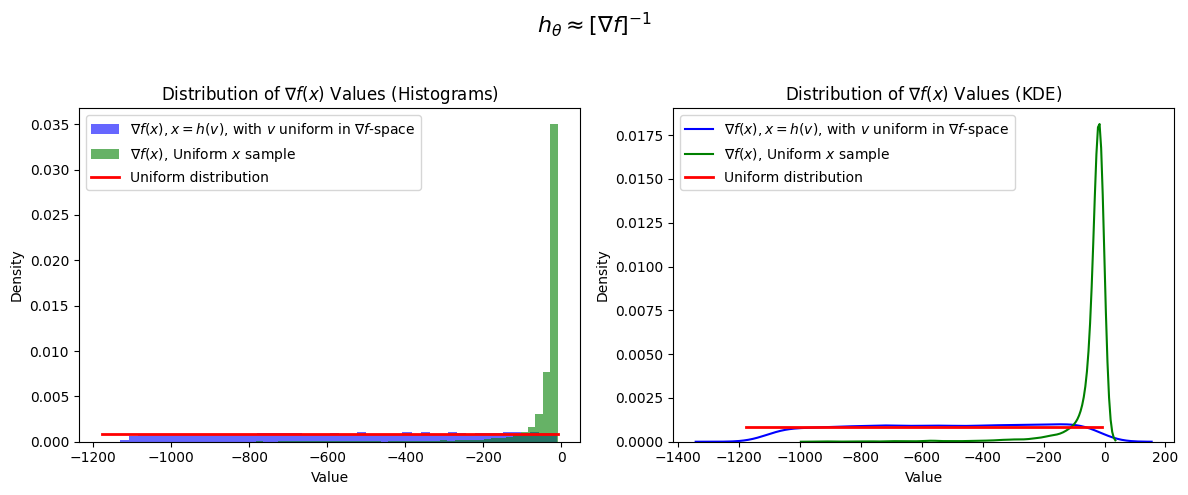

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_distributions(x_inverse_sampling, x_uniform_sampling, psi, bins=50, figsize=(12, 5)):
    # Generate data
    x_uniform = next(x_uniform_sampling)
    x = next(x_inverse_sampling)

    plt.figure(figsize=(8, 6), dpi=DPI)  # Set the DPI to 300

    plt.scatter(x_uniform[:, 0], x_uniform[:, 1], c='red', label='eval_batch_x2')
    plt.scatter(x[:, 0], x[:, 1], c='blue', label='eval_batch_x')

    plt.title(f'Eval Batch X1 and X2')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.grid(True)

    plt.show()

    # Select one dimension to analyze (e.g., the first dimension)
    selected_values = np.array([psi(xi) for xi in x])[:, 0]
    uniform_values = np.array([psi(xj) for xj in x_uniform])[:, 0]

    # Calculate the interval length
    minval = min(selected_values.min(), uniform_values.min())
    maxval = max(selected_values.max(), uniform_values.max())
    interval_length = maxval - minval

    print(interval_length)

    # Create a figure and subplots with DPI set to 300
    fig, axs = plt.subplots(1, 2, figsize=figsize, dpi=DPI)

    # Plot histograms on the first subplot
    axs[0].hist(selected_values, bins=bins, density=True, alpha=0.6, color='blue',
                label='$\\nabla f (x), x = h(v)$, with $v$ uniform in $\\nabla f$-space')
    axs[0].hist(uniform_values, bins=bins, density=True, alpha=0.6, color='green',
                label='$\\nabla f (x)$, Uniform $x$ sample')
    axs[0].plot([minval, maxval], [1 / interval_length, 1 / interval_length], color='red',
                linestyle='-', linewidth=2, label='Uniform distribution')
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Density')
    axs[0].legend()
    axs[0].set_title('Distribution of $\\nabla f (x)$ Values (Histograms)')

    # Plot KDEs on the second subplot
    sns.kdeplot(selected_values, label='$\\nabla f (x), x = h(v)$, with $v$ uniform in $\\nabla f$-space',
                color='blue', ax=axs[1])
    sns.kdeplot(uniform_values, label='$\\nabla f (x)$, Uniform $x$ sample', color='green', ax=axs[1])
    axs[1].plot([minval, maxval], [1 / interval_length, 1 / interval_length], color='red',
                linestyle='-', linewidth=2, label='Uniform distribution')
    axs[1].set_xlabel('Value')
    axs[1].set_ylabel('Density')
    axs[1].legend()
    axs[1].set_title('Distribution of $\\nabla f (x)$ Values (KDE)')

    # Add LaTeX notation to indicate $h_\theta$ approximation
    fig.suptitle('$h_\\theta \\approx [\\nabla f]^{-1}$', fontsize=16)

    # Adjust spacing between subplots and show the plots
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to make space for suptitle
    plt.show()

# usage
plot_distributions(x_inverse_sampling, x_uniform_sampling, psi)


In [ ]:
# test_x = x_inverse_sampling#x_inverse_sampling #if cfg.test_sampling else x_uniform_sampling
# test_x2 = x_uniform_sampling

# eval_batch_x, eval_y, eval_grad_f_x = get_next_batch(test_x)
# eval_batch_x2, eval_y2, eval_grad_f_x2 = get_next_batch(test_x2)

# plt.figure(figsize=(8, 6))

# plt.scatter(eval_batch_x[:, 0], eval_batch_x[:, 1], c='blue', label='eval_batch_x')
# plt.scatter(eval_batch_x2[:, 0], eval_batch_x2[:, 1], c='red', label='eval_batch_x2')

# plt.title(f'Eval Batch X1 and X2 at Epoch {epoch}')
# plt.xlabel('X1')
# plt.ylabel('X2')
# plt.legend()
# plt.grid(True)

# plt.show()

## Train the model:

In [ ]:
x_inverse_sampling = create_inverse_uniform_sampling_random_generator(cfg, key, cfg.minval, cfg.maxval, encoder_params, apply_encoder) # approximate inverse of nu: ~ [nabla f]^-1 (mu)
x_uniform_sampling = x_uniform_sampling_generator(cfg, key, minval_x=cfg.start, maxval_x=cfg.end) # uniform in C
y_uniform_sampling = y_uniform_sampling_generator(cfg, key, minval_y=cfg.minval, maxval_y=cfg.maxval) # uniform in D

In [ ]:
def get_next_batch(train_generator):
    # Define the range and resolution for each dimension
    start = cfg.start
    end = cfg.end
    num_points = 0 #cfg.n
    useGrid = False #cfg.use_grid

    if useGrid:
        # Create d-dimensional meshgrid
        meshgrids = [jnp.linspace(start, end, num_points) for _ in range(d)]
        meshgrid_dD = jnp.stack(jnp.meshgrid(*meshgrids), axis=-1)
        x = meshgrid_dD.reshape((-1, d))
        f_x = vmap_f(x).reshape((-1, 1))
        grad_f_x = vmap_grad_f(x).reshape((-1, d))
    else:  # Use mini-batch approach
        x = next(train_generator).reshape((-1, d))
        f_x = vmap_f(x).reshape((-1, 1))
        grad_f_x = vmap_grad_f(x).reshape((-1, d))

    return x, f_x, grad_f_x

In [ ]:
# def run_experiment(cfg):
# Initialize loss list to store the training loss values
Loss = []
d = cfg.dim
layer_sizes = cfg.layer_widths
initial_key = jax.random.PRNGKey(0)

# Function mappings
f = function_mapping[cfg.f_func]
f_star_true = function_mapping[cfg.f_func_star]

train_x = x_inverse_sampling if cfg.train_sampling else x_uniform_sampling
test_x = x_inverse_sampling if cfg.test_sampling else x_uniform_sampling
test_x2 = x_uniform_sampling

test_y = y_uniform_sampling # sample from the target distribution nu
# test_y2 = get_next_batch(x_uniform_sampling)[2] # image of x with distibution mu (we will use test_x2 that let one generate the same + evaluate losses of the model)

# Initialize the model
# Dummy data
batch_x, train_y, train_grad_f_x = get_next_batch(train_x)

# Model and optimizer setup
layer_widths = cfg.layer_widths
model = ConvexNN(activation=nn.softplus, layer_widths=layer_widths)# FCNN(activation=nn.softplus, layer_widths=layer_widths)#ConvexNN(activation=nn.softplus, layer_widths=layer_widths)

key = random.PRNGKey(0)
x_dummy = jnp.ones((1, d))
params = model.init(key, x_dummy)['params']

initial_learning_rate = 3e-2
min_learning_rate = 1e-9
lr_schedule = optax.exponential_decay(init_value=initial_learning_rate, transition_steps=1000, decay_rate=0.95, end_value=min_learning_rate, staircase=True)

# Define the gradient clipping transformation
grad_clip = optax.clip_by_global_norm(1.0)

# Combine the optimizer with gradient clipping
optimizer = optax.chain(
    grad_clip,
    optax.adam(learning_rate=lr_schedule)
)

# Training state
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

@jax.jit
def train_step(state, inputs_x, inputs_grad_f_x, targets):
    # Adjust the pure_loss_fn to include all necessary arguments
    def pure_loss_fn(params, inputs_x, inputs_grad_f_x, targets):
        y = inputs_grad_f_x
        x = inputs_x
        predictions = jnp.sum(x * y, axis=-1).reshape(-1, 1) - jnp.squeeze(state.apply_fn({'params': params}, y)).reshape(-1, 1)
        loss = jnp.mean((predictions.reshape(-1, 1) - targets.reshape(-1, 1)) ** 2)
        return loss

    # Bind the additional arguments to loss_fn before differentiation
    loss_fn = partial(pure_loss_fn, inputs_x=inputs_x, inputs_grad_f_x=inputs_grad_f_x, targets=targets)
    grads = jax.grad(loss_fn, argnums=0)(state.params)
    new_state = state.apply_gradients(grads=grads)
    loss_value = loss_fn(state.params)  # Recompute loss after update for logging/monitoring
    return new_state, loss_value



# LOSS FOR PLOTTING PURPOSES:
# we do not use regularizers
def print_loss_fn(params, inputs_x, inputs_grad_f_x, targets, use_regularizer = False):
    def pure_loss_fn(params, inputs_x, inputs_grad_f_x, targets):
        y = inputs_grad_f_x
        x = inputs_x
        predictions = jnp.sum(x * y, axis=-1).reshape(-1, 1) - jnp.squeeze(state.apply_fn({'params': params}, y)).reshape(-1, 1)
        loss = jnp.mean((predictions.reshape(-1, 1) - targets.reshape(-1, 1)) ** 2)
        return loss
    loss = pure_loss_fn(params, inputs_x, inputs_grad_f_x, targets)
    return loss

In [ ]:
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize the timing and progress tracking
tic = time.time()
epoch = 0  # Initialize epoch counter
N = cfg.num_epochs  # Total number of epochs
# Initialize tqdm progress bar
pbar = tqdm(total=N, desc="Processing", position=0, leave=True)

converged = False

# Initialize variables to track the best RMSE and the corresponding epoch
best_rmse = float('inf')
best_epoch = 0

eval_loss_fn = print_loss_fn

# List to store statistics for each evaluation
statistics_list = []

# Lists to store losses for later analysis
train_losses = []
eval_losses = []

while epoch < N - 1:

    # Get the next batch of data
    batch_x, train_y, train_grad_f_x = get_next_batch(train_x)

    if epoch % 3 == 0:
        batch_x, train_y, train_grad_f_x = get_next_batch(x_uniform_sampling)

    current_lr = lr_schedule(epoch)

    for _ in range(cfg.steps):
        # Update the model using the training step function
        state, loss_value = train_step(state, batch_x, train_grad_f_x, train_y)
        pbar.update(1)

    # Increment the epoch counter after each full pass through the data
    epoch += 1

    # Store the train loss
    train_losses.append(loss_value)

    # Evaluate the model periodically
    if epoch % 10000 == 0 or epoch == N - 2:

        # Evaluate the model on the test set [naba f](mu); where mu1 = approximate inverse_of_nu, if test_sampling = true and uniform otherwise
        eval_batch_x, eval_y, eval_grad_f_x = get_next_batch(test_x)
        eval_loss_value = eval_loss_fn(state.params, eval_batch_x, eval_grad_f_x, targets=eval_y)
        preds = model.apply({'params': state.params}, eval_grad_f_x)
        acc, acc_max, mre = calculate_statistics(eval_grad_f_x, preds, vmap_f_star_true)
        RMSE = jnp.sqrt(eval_loss_value)

        # Store the eval loss
        eval_losses.append(eval_loss_value)

        # Track the best RMSE and corresponding epoch
        if RMSE < best_rmse:
            best_rmse = RMSE
            best_epoch = epoch

        # Calculate statistics for y_nu
        y_nu = next(test_y)
        preds_y_nu = model.apply({'params': state.params}, y_nu)
        acc_y_nu, acc_max_y_nu, mre_y_nu = calculate_statistics(y_nu, preds_y_nu, vmap_f_star_true)

        # Evaluate the model on the test set [naba f](mu2); where mu2 is uniform
        eval_batch_x2, eval_y2, eval_grad_f_x2 = get_next_batch(test_x2)
        preds2 = model.apply({'params': state.params}, eval_grad_f_x2)
        eval_loss_value2 = eval_loss_fn(state.params, eval_batch_x2, eval_grad_f_x2, targets=eval_y2)
        acc2, acc_max2, mre2 = calculate_statistics(eval_grad_f_x2, preds2, vmap_f_star_true)
        RMSE2 = jnp.sqrt(eval_loss_value2)

        print(f"\nEvaluation after {epoch} epochs:")
        print(f"Train Loss = {loss_value}")
        print(f"Eval Loss = {eval_loss_value}")
        print(f"Best RMSE so far: {best_rmse} at epoch {best_epoch}")

        print(f"\nMeasure approx_nu (approx_nu~nu in D) results")
        print(f"Accuracy = {acc}, Max Accuracy = {acc_max}, RMSE = {RMSE}, Mean Relative Error = {mre}")

        print(f"\nMeasure 'nu' results")
        print(f"Accuracy (y_nu) = {acc_y_nu}, Max Accuracy (y_nu) = {acc_max_y_nu}, Mean Relative Error (y_nu) = {mre_y_nu}")

        print(f"Additional Test on Test Set 2 after {epoch} epochs:")
        print(f"\nMeasure 'nabla f (mu)' (mu is uniform in C) results")
        print(f"Eval Loss 2 = {eval_loss_value2}")
        print(f"Accuracy 2 = {acc2}, Max Accuracy 2 = {acc_max2}, RMSE 2 = {RMSE2}, Mean Relative Error 2 = {mre2}")

        print("================================================================")
        # Store statistics for this evaluation
        statistics = {
            'epoch': epoch,
            'train_loss': loss_value,
            'eval_loss': eval_loss_value,
            'best_rmse': best_rmse,
            'best_epoch': best_epoch,
            'accuracy_mu1': acc.tolist(),
            'max_accuracy_mu1': acc_max.tolist(),
            'residual_mu1': RMSE.tolist(),
            'mean_relative_error_mu1': mre,
            'accuracy_y_nu': acc_y_nu.tolist(),
            'max_accuracy_y_nu': acc_max_y_nu.tolist(),
            'mean_relative_error_y_nu': mre_y_nu,
            'eval_loss_2': eval_loss_value2,
            'accuracy_mu2': acc2.tolist(),
            'max_accuracy_mu2': acc_max2.tolist(),
            'residual_mu2': RMSE2.tolist(),
            'mean_relative_error_mu2': mre2,
            'learning_rate': current_lr,
            'converged': converged,
            'runtime': time.time() - tic,
            'description': cfg.description,
        }

        statistics_list.append(statistics)

        if RMSE < cfg.convrg_eps:
            toc = time.time()
            duration = toc - tic
            print(f"CONVERGED AFTER {duration:.4f} [s], and {epoch} epochs, res = {RMSE}, accuracy = {acc}")
            print(f"Final Best RMSE: {best_rmse} at epoch {best_epoch}")
            pbar.close()
            converged = True
            break
        else:
            tqdm.write(f"\n Test RMSE after {epoch} epochs = {RMSE}")
            tqdm.write(f"\n Epoch {epoch}, Loss: {loss_value:.6f}, LR: {current_lr:.6f}")
            tqdm.write(f"Test metrics after {epoch} epochs: Accuracy = {acc:.4f}, MSE (Residual) = {RMSE:.4f}, MRE = {mre:.4f}, Uniform Err = {acc_max:.4f}")

# Convert the losses to floats and print them
train_loss_list = [float(value) for value in train_losses]
eval_loss_list = [float(value) for value in eval_losses]

Processing:   5%|▌         | 10011/200000 [02:49<3:26:46, 15.31it/s]


Evaluation after 10000 epochs:
Train Loss = 2745.657958984375
Eval Loss = 28.542360305786133
Best RMSE so far: 5.342504978179932 at epoch 10000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 5.34250545501709, Max Accuracy = 16.181190490722656, RMSE = 5.342504978179932, Mean Relative Error = 0.03118816390633583

Measure 'nu' results
Accuracy (y_nu) = 4.272902011871338, Max Accuracy (y_nu) = 13.780235290527344, Mean Relative Error (y_nu) = 0.02489554136991501
Additional Test on Test Set 2 after 10000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 2745.869140625
Accuracy 2 = 52.401039123535156, Max Accuracy 2 = 65.37567138671875, RMSE 2 = 52.401039123535156, Mean Relative Error 2 = 0.6172091960906982

 Test RMSE after 10000 epochs = 5.342504978179932

 Epoch 10000, Loss: 2745.657959, LR: 0.018907
Test metrics after 10000 epochs: Accuracy = 5.3425, MSE (Residual) = 5.3425, MRE = 0.0312, Uniform Err = 16.1812


Processing:  10%|█         | 20005/200000 [05:35<1:06:39, 45.00it/s]


Evaluation after 20000 epochs:
Train Loss = 16.030351638793945
Eval Loss = 15.727807998657227
Best RMSE so far: 3.965830087661743 at epoch 20000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 3.965830087661743, Max Accuracy = 17.121253967285156, RMSE = 3.965830087661743, Mean Relative Error = 0.022730683907866478

Measure 'nu' results
Accuracy (y_nu) = 3.9954826831817627, Max Accuracy (y_nu) = 20.906105041503906, Mean Relative Error (y_nu) = 0.022704239934682846
Additional Test on Test Set 2 after 20000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 2717.700439453125
Accuracy 2 = 52.131568908691406, Max Accuracy 2 = 85.4594497680664, RMSE 2 = 52.131568908691406, Mean Relative Error 2 = 0.6002117395401001

 Test RMSE after 20000 epochs = 3.965830087661743

 Epoch 20000, Loss: 16.030352, LR: 0.011321
Test metrics after 20000 epochs: Accuracy = 3.9658, MSE (Residual) = 3.9658, MRE = 0.0227, Uniform Err = 17.1213


Processing:  15%|█▌        | 30011/200000 [08:22<55:19, 51.21it/s]


Evaluation after 30000 epochs:
Train Loss = 12.608798027038574
Eval Loss = 13.151956558227539
Best RMSE so far: 3.6265625953674316 at epoch 30000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 3.6265625953674316, Max Accuracy = 15.612480163574219, RMSE = 3.6265625953674316, Mean Relative Error = 0.020641736686229706

Measure 'nu' results
Accuracy (y_nu) = 3.886378765106201, Max Accuracy (y_nu) = 14.349739074707031, Mean Relative Error (y_nu) = 0.02263016812503338
Additional Test on Test Set 2 after 30000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 15.283914566040039
Accuracy 2 = 3.9094645977020264, Max Accuracy 2 = 13.135589599609375, RMSE 2 = 3.9094645977020264, Mean Relative Error 2 = 0.03984349966049194

 Test RMSE after 30000 epochs = 3.6265625953674316

 Epoch 30000, Loss: 12.608798, LR: 0.006778
Test metrics after 30000 epochs: Accuracy = 3.6266, MSE (Residual) = 3.6266, MRE = 0.0206, Uniform Err = 15.6125


Processing:  20%|██        | 40009/200000 [11:09<53:47, 49.56it/s]


Evaluation after 40000 epochs:
Train Loss = 6.464081764221191
Eval Loss = 27.795297622680664
Best RMSE so far: 3.6265625953674316 at epoch 30000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 5.272124767303467, Max Accuracy = 22.40125274658203, RMSE = 5.272124290466309, Mean Relative Error = 0.030016450211405754

Measure 'nu' results
Accuracy (y_nu) = 5.681913375854492, Max Accuracy (y_nu) = 22.277565002441406, Mean Relative Error (y_nu) = 0.03231918811798096
Additional Test on Test Set 2 after 40000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 4.898426055908203
Accuracy 2 = 2.2132389545440674, Max Accuracy 2 = 10.915122985839844, RMSE 2 = 2.2132387161254883, Mean Relative Error 2 = 0.019370703026652336

 Test RMSE after 40000 epochs = 5.272124290466309

 Epoch 40000, Loss: 6.464082, LR: 0.004058
Test metrics after 40000 epochs: Accuracy = 5.2721, MSE (Residual) = 5.2721, MRE = 0.0300, Uniform Err = 22.4013


Processing:  25%|██▌       | 50005/200000 [13:58<54:25, 45.93it/s]


Evaluation after 50000 epochs:
Train Loss = 14.371193885803223
Eval Loss = 9.230509757995605
Best RMSE so far: 3.038175344467163 at epoch 50000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 3.038175582885742, Max Accuracy = 12.024215698242188, RMSE = 3.038175344467163, Mean Relative Error = 0.017531970515847206

Measure 'nu' results
Accuracy (y_nu) = 2.9946978092193604, Max Accuracy (y_nu) = 14.657257080078125, Mean Relative Error (y_nu) = 0.017290636897087097
Additional Test on Test Set 2 after 50000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 9.311875343322754
Accuracy 2 = 3.0515365600585938, Max Accuracy 2 = 10.105094909667969, RMSE 2 = 3.0515365600585938, Mean Relative Error 2 = 0.030252674594521523

 Test RMSE after 50000 epochs = 3.038175344467163

 Epoch 50000, Loss: 14.371194, LR: 0.002430
Test metrics after 50000 epochs: Accuracy = 3.0382, MSE (Residual) = 3.0382, MRE = 0.0175, Uniform Err = 12.0242


Processing:  30%|███       | 60004/200000 [16:45<54:01, 43.19it/s]


Evaluation after 60000 epochs:
Train Loss = 4.429213047027588
Eval Loss = 4.121163845062256
Best RMSE so far: 2.0300650596618652 at epoch 60000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 2.0300650596618652, Max Accuracy = 9.849395751953125, RMSE = 2.0300650596618652, Mean Relative Error = 0.011244691908359528

Measure 'nu' results
Accuracy (y_nu) = 1.7493197917938232, Max Accuracy (y_nu) = 8.275932312011719, Mean Relative Error (y_nu) = 0.010059542953968048
Additional Test on Test Set 2 after 60000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 2.8626413345336914
Accuracy 2 = 1.6919341087341309, Max Accuracy 2 = 8.076644897460938, RMSE 2 = 1.6919342279434204, Mean Relative Error 2 = 0.015618771314620972

 Test RMSE after 60000 epochs = 2.0300650596618652

 Epoch 60000, Loss: 4.429213, LR: 0.001455
Test metrics after 60000 epochs: Accuracy = 2.0301, MSE (Residual) = 2.0301, MRE = 0.0112, Uniform Err = 9.8494


Processing:  35%|███▌      | 70010/200000 [19:34<44:27, 48.73it/s]


Evaluation after 70000 epochs:
Train Loss = 2.0311219692230225
Eval Loss = 6.628316879272461
Best RMSE so far: 2.0300650596618652 at epoch 60000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 2.574551820755005, Max Accuracy = 10.225936889648438, RMSE = 2.574551820755005, Mean Relative Error = 0.01537096593528986

Measure 'nu' results
Accuracy (y_nu) = 3.0082709789276123, Max Accuracy (y_nu) = 10.54913330078125, Mean Relative Error (y_nu) = 0.018781043589115143
Additional Test on Test Set 2 after 70000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 1.750662922859192
Accuracy 2 = 1.323126196861267, Max Accuracy 2 = 7.226249694824219, RMSE 2 = 1.323126196861267, Mean Relative Error 2 = 0.011772183701395988

 Test RMSE after 70000 epochs = 2.574551820755005

 Epoch 70000, Loss: 2.031122, LR: 0.000871
Test metrics after 70000 epochs: Accuracy = 2.5746, MSE (Residual) = 2.5746, MRE = 0.0154, Uniform Err = 10.2259


Processing:  40%|████      | 80005/200000 [22:22<44:18, 45.14it/s]


Evaluation after 80000 epochs:
Train Loss = 3.2108891010284424
Eval Loss = 3.2151670455932617
Best RMSE so far: 1.793088674545288 at epoch 80000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 1.7930889129638672, Max Accuracy = 10.4825439453125, RMSE = 1.793088674545288, Mean Relative Error = 0.010315385647118092

Measure 'nu' results
Accuracy (y_nu) = 2.018252372741699, Max Accuracy (y_nu) = 12.403984069824219, Mean Relative Error (y_nu) = 0.012083075940608978
Additional Test on Test Set 2 after 80000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 1.4711426496505737
Accuracy 2 = 1.2129067182540894, Max Accuracy 2 = 7.0198974609375, RMSE 2 = 1.2129067182540894, Mean Relative Error 2 = 0.010734345763921738

 Test RMSE after 80000 epochs = 1.793088674545288

 Epoch 80000, Loss: 3.210889, LR: 0.000522
Test metrics after 80000 epochs: Accuracy = 1.7931, MSE (Residual) = 1.7931, MRE = 0.0103, Uniform Err = 10.4825


Processing:  45%|████▌     | 90008/200000 [25:10<36:36, 50.07it/s]


Evaluation after 90000 epochs:
Train Loss = 3.071532964706421
Eval Loss = 2.9377248287200928
Best RMSE so far: 1.7139792442321777 at epoch 90000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 1.7139792442321777, Max Accuracy = 11.200057983398438, RMSE = 1.7139792442321777, Mean Relative Error = 0.00977472122758627

Measure 'nu' results
Accuracy (y_nu) = 1.8490700721740723, Max Accuracy (y_nu) = 7.54217529296875, Mean Relative Error (y_nu) = 0.01101970486342907
Additional Test on Test Set 2 after 90000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 1.4120370149612427
Accuracy 2 = 1.1882915496826172, Max Accuracy 2 = 6.3157196044921875, RMSE 2 = 1.1882915496826172, Mean Relative Error 2 = 0.010544529184699059

 Test RMSE after 90000 epochs = 1.7139792442321777

 Epoch 90000, Loss: 3.071533, LR: 0.000312
Test metrics after 90000 epochs: Accuracy = 1.7140, MSE (Residual) = 1.7140, MRE = 0.0098, Uniform Err = 11.2001


Processing:  50%|█████     | 100009/200000 [27:58<33:40, 49.50it/s]


Evaluation after 100000 epochs:
Train Loss = 1.274263858795166
Eval Loss = 2.822733163833618
Best RMSE so far: 1.6800991296768188 at epoch 100000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 1.6800990104675293, Max Accuracy = 9.144515991210938, RMSE = 1.6800991296768188, Mean Relative Error = 0.009429285302758217

Measure 'nu' results
Accuracy (y_nu) = 1.6620010137557983, Max Accuracy (y_nu) = 7.282432556152344, Mean Relative Error (y_nu) = 0.009852472692728043
Additional Test on Test Set 2 after 100000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 1.207626223564148
Accuracy 2 = 1.0989203453063965, Max Accuracy 2 = 5.2812957763671875, RMSE 2 = 1.098920464515686, Mean Relative Error 2 = 0.009784913621842861

 Test RMSE after 100000 epochs = 1.6800991296768188

 Epoch 100000, Loss: 1.274264, LR: 0.000187
Test metrics after 100000 epochs: Accuracy = 1.6801, MSE (Residual) = 1.6801, MRE = 0.0094, Uniform Err = 9.1445


Processing:  55%|█████▌    | 110005/200000 [30:46<33:20, 44.99it/s]


Evaluation after 110000 epochs:
Train Loss = 2.576215982437134
Eval Loss = 2.7349660396575928
Best RMSE so far: 1.653773307800293 at epoch 110000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 1.6537731885910034, Max Accuracy = 7.6517486572265625, RMSE = 1.653773307800293, Mean Relative Error = 0.009301030077040195

Measure 'nu' results
Accuracy (y_nu) = 1.6607654094696045, Max Accuracy (y_nu) = 6.390052795410156, Mean Relative Error (y_nu) = 0.009790275245904922
Additional Test on Test Set 2 after 110000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 1.2541898488998413
Accuracy 2 = 1.1199060678482056, Max Accuracy 2 = 6.387977600097656, RMSE 2 = 1.1199061870574951, Mean Relative Error 2 = 0.009853583760559559

 Test RMSE after 110000 epochs = 1.653773307800293

 Epoch 110000, Loss: 2.576216, LR: 0.000112
Test metrics after 110000 epochs: Accuracy = 1.6538, MSE (Residual) = 1.6538, MRE = 0.0093, Uniform Err = 7.6517


Processing:  60%|██████    | 120005/200000 [33:35<29:19, 45.47it/s]


Evaluation after 120000 epochs:
Train Loss = 2.653656244277954
Eval Loss = 2.6110777854919434
Best RMSE so far: 1.6158829927444458 at epoch 120000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 1.6158829927444458, Max Accuracy = 7.7693939208984375, RMSE = 1.6158829927444458, Mean Relative Error = 0.009149642661213875

Measure 'nu' results
Accuracy (y_nu) = 1.654683232307434, Max Accuracy (y_nu) = 7.9462890625, Mean Relative Error (y_nu) = 0.00974888727068901
Additional Test on Test Set 2 after 120000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 1.2749087810516357
Accuracy 2 = 1.12911856174469, Max Accuracy 2 = 6.840461730957031, RMSE 2 = 1.12911856174469, Mean Relative Error 2 = 0.009968114085495472

 Test RMSE after 120000 epochs = 1.6158829927444458

 Epoch 120000, Loss: 2.653656, LR: 0.000067
Test metrics after 120000 epochs: Accuracy = 1.6159, MSE (Residual) = 1.6159, MRE = 0.0091, Uniform Err = 7.7694


Processing:  65%|██████▌   | 130009/200000 [36:23<24:26, 47.73it/s]


Evaluation after 130000 epochs:
Train Loss = 1.2354035377502441
Eval Loss = 2.5817551612854004
Best RMSE so far: 1.6067841053009033 at epoch 130000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 1.6067839860916138, Max Accuracy = 7.128204345703125, RMSE = 1.6067841053009033, Mean Relative Error = 0.009144150651991367

Measure 'nu' results
Accuracy (y_nu) = 1.6570606231689453, Max Accuracy (y_nu) = 7.486335754394531, Mean Relative Error (y_nu) = 0.009842928498983383
Additional Test on Test Set 2 after 130000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 1.2639650106430054
Accuracy 2 = 1.1242619752883911, Max Accuracy 2 = 5.9839630126953125, RMSE 2 = 1.1242619752883911, Mean Relative Error 2 = 0.00996436644345522

 Test RMSE after 130000 epochs = 1.6067841053009033

 Epoch 130000, Loss: 1.235404, LR: 0.000040
Test metrics after 130000 epochs: Accuracy = 1.6068, MSE (Residual) = 1.6068, MRE = 0.0091, Uniform Err = 7.1282


Processing:  70%|███████   | 140007/200000 [39:11<21:54, 45.65it/s]


Evaluation after 140000 epochs:
Train Loss = 2.507253408432007
Eval Loss = 2.414201498031616
Best RMSE so far: 1.5537700653076172 at epoch 140000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 1.5537700653076172, Max Accuracy = 7.43560791015625, RMSE = 1.5537700653076172, Mean Relative Error = 0.008869501762092113

Measure 'nu' results
Accuracy (y_nu) = 1.6681766510009766, Max Accuracy (y_nu) = 6.4945831298828125, Mean Relative Error (y_nu) = 0.00988833699375391
Additional Test on Test Set 2 after 140000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 1.2324055433273315
Accuracy 2 = 1.1101375818252563, Max Accuracy 2 = 6.0169830322265625, RMSE 2 = 1.1101375818252563, Mean Relative Error 2 = 0.009919382631778717

 Test RMSE after 140000 epochs = 1.5537700653076172

 Epoch 140000, Loss: 2.507253, LR: 0.000024
Test metrics after 140000 epochs: Accuracy = 1.5538, MSE (Residual) = 1.5538, MRE = 0.0089, Uniform Err = 7.4356


Processing:  75%|███████▌  | 150008/200000 [41:59<16:49, 49.54it/s]


Evaluation after 150000 epochs:
Train Loss = 2.5505728721618652
Eval Loss = 2.444593667984009
Best RMSE so far: 1.5537700653076172 at epoch 140000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 1.5635195970535278, Max Accuracy = 7.791259765625, RMSE = 1.5635195970535278, Mean Relative Error = 0.008854405954480171

Measure 'nu' results
Accuracy (y_nu) = 1.6293110847473145, Max Accuracy (y_nu) = 8.014968872070312, Mean Relative Error (y_nu) = 0.009636396542191505
Additional Test on Test Set 2 after 150000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 1.273219347000122
Accuracy 2 = 1.1283702850341797, Max Accuracy 2 = 9.707733154296875, RMSE 2 = 1.1283701658248901, Mean Relative Error 2 = 0.01001552864909172

 Test RMSE after 150000 epochs = 1.5635195970535278

 Epoch 150000, Loss: 2.550573, LR: 0.000014
Test metrics after 150000 epochs: Accuracy = 1.5635, MSE (Residual) = 1.5635, MRE = 0.0089, Uniform Err = 7.7913


Processing:  80%|████████  | 160010/200000 [44:46<13:08, 50.70it/s]


Evaluation after 160000 epochs:
Train Loss = 1.3007298707962036
Eval Loss = 2.476162910461426
Best RMSE so far: 1.5537700653076172 at epoch 140000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 1.5735827684402466, Max Accuracy = 8.098274230957031, RMSE = 1.5735827684402466, Mean Relative Error = 0.008912023156881332

Measure 'nu' results
Accuracy (y_nu) = 1.6582714319229126, Max Accuracy (y_nu) = 7.2037200927734375, Mean Relative Error (y_nu) = 0.009884292259812355
Additional Test on Test Set 2 after 160000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 1.232312798500061
Accuracy 2 = 1.110095739364624, Max Accuracy 2 = 9.094718933105469, RMSE 2 = 1.1100958585739136, Mean Relative Error 2 = 0.009987074881792068

 Test RMSE after 160000 epochs = 1.5735827684402466

 Epoch 160000, Loss: 1.300730, LR: 0.000009
Test metrics after 160000 epochs: Accuracy = 1.5736, MSE (Residual) = 1.5736, MRE = 0.0089, Uniform Err = 8.0983


Processing:  85%|████████▌ | 170010/200000 [47:36<09:59, 50.03it/s]


Evaluation after 170000 epochs:
Train Loss = 2.5008912086486816
Eval Loss = 2.529956579208374
Best RMSE so far: 1.5537700653076172 at epoch 140000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 1.5905836820602417, Max Accuracy = 7.5956878662109375, RMSE = 1.5905838012695312, Mean Relative Error = 0.009081077761948109

Measure 'nu' results
Accuracy (y_nu) = 1.6108835935592651, Max Accuracy (y_nu) = 6.3311920166015625, Mean Relative Error (y_nu) = 0.009600040502846241
Additional Test on Test Set 2 after 170000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 1.2520250082015991
Accuracy 2 = 1.1189392805099487, Max Accuracy 2 = 7.379249572753906, RMSE 2 = 1.1189391613006592, Mean Relative Error 2 = 0.010020127519965172

 Test RMSE after 170000 epochs = 1.5905838012695312

 Epoch 170000, Loss: 2.500891, LR: 0.000005
Test metrics after 170000 epochs: Accuracy = 1.5906, MSE (Residual) = 1.5906, MRE = 0.0091, Uniform Err = 7.5957


Processing:  90%|█████████ | 180008/200000 [50:24<06:36, 50.37it/s]


Evaluation after 180000 epochs:
Train Loss = 2.457073926925659
Eval Loss = 2.519237995147705
Best RMSE so far: 1.5537700653076172 at epoch 140000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 1.587210774421692, Max Accuracy = 7.361175537109375, RMSE = 1.587210774421692, Mean Relative Error = 0.008987276814877987

Measure 'nu' results
Accuracy (y_nu) = 1.6297504901885986, Max Accuracy (y_nu) = 6.836036682128906, Mean Relative Error (y_nu) = 0.009727089665830135
Additional Test on Test Set 2 after 180000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 1.2524043321609497
Accuracy 2 = 1.1191086769104004, Max Accuracy 2 = 6.129951477050781, RMSE 2 = 1.1191086769104004, Mean Relative Error 2 = 0.010105679742991924

 Test RMSE after 180000 epochs = 1.587210774421692

 Epoch 180000, Loss: 2.457074, LR: 0.000003
Test metrics after 180000 epochs: Accuracy = 1.5872, MSE (Residual) = 1.5872, MRE = 0.0090, Uniform Err = 7.3612


Processing:  95%|█████████▌| 190007/200000 [53:12<03:26, 48.31it/s]


Evaluation after 190000 epochs:
Train Loss = 1.2428169250488281
Eval Loss = 2.483193874359131
Best RMSE so far: 1.5537700653076172 at epoch 140000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 1.5758153200149536, Max Accuracy = 8.054061889648438, RMSE = 1.5758153200149536, Mean Relative Error = 0.00901760347187519

Measure 'nu' results
Accuracy (y_nu) = 1.5938578844070435, Max Accuracy (y_nu) = 6.5362396240234375, Mean Relative Error (y_nu) = 0.009432750754058361
Additional Test on Test Set 2 after 190000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 1.2694061994552612
Accuracy 2 = 1.1266791820526123, Max Accuracy 2 = 6.1772918701171875, RMSE 2 = 1.1266793012619019, Mean Relative Error 2 = 0.010016486980021

 Test RMSE after 190000 epochs = 1.5758153200149536

 Epoch 190000, Loss: 1.242817, LR: 0.000002
Test metrics after 190000 epochs: Accuracy = 1.5758, MSE (Residual) = 1.5758, MRE = 0.0090, Uniform Err = 8.0541


Processing: 100%|█████████▉| 199998/200000 [56:00<00:00, 61.16it/s]


Evaluation after 199998 epochs:
Train Loss = 2.495755910873413
Eval Loss = 2.5390870571136475
Best RMSE so far: 1.5537700653076172 at epoch 140000

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 1.5934512615203857, Max Accuracy = 8.052947998046875, RMSE = 1.5934512615203857, Mean Relative Error = 0.009038097225129604

Measure 'nu' results
Accuracy (y_nu) = 1.6218665838241577, Max Accuracy (y_nu) = 6.6313018798828125, Mean Relative Error (y_nu) = 0.009600209072232246
Additional Test on Test Set 2 after 199998 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 1.2584365606307983
Accuracy 2 = 1.1218005418777466, Max Accuracy 2 = 8.043731689453125, RMSE 2 = 1.1218005418777466, Mean Relative Error 2 = 0.009977655485272408

 Test RMSE after 199998 epochs = 1.5934512615203857

 Epoch 199998, Loss: 2.495756, LR: 0.000001
Test metrics after 199998 epochs: Accuracy = 1.5935, MSE (Residual) = 1.5935, MRE = 0.0090, Uniform Err = 8.0529


Processing: 100%|█████████▉| 199999/200000 [56:10<00:00, 61.16it/s]

In [ ]:
from datetime import timedelta

# Find the statistics corresponding to the best RMSE
best_stat = min(statistics_list, key=lambda x: x['best_rmse'])

# Print the best statistics
print("\nBest Evaluation Results:")
print(f"\nEvaluation after {best_stat['epoch']} epochs:")
print(f"Train Loss = {best_stat['train_loss']:.6f}")
print(f"Eval Loss = {best_stat['eval_loss']:.6f}")
print(f"Best RMSE = {best_stat['best_rmse']:.6f} at epoch {best_stat['best_epoch']}")

runtime_seconds = best_stat['runtime']
runtime_formatted = str(timedelta(seconds=runtime_seconds))
print(f"Total Runtime = {runtime_formatted}")

print(f"\nMeasure approx_nu (approx_nu~nu in D) results")
print(f"Accuracy = {best_stat['accuracy_mu1']}, Max Accuracy = {best_stat['max_accuracy_mu1']}, RMSE = {best_stat['residual_mu1']:.6f}, Mean Relative Error = {best_stat['mean_relative_error_mu1']:.6f}")

print(f"\nMeasure 'nu' results")
print(f"Accuracy (y_nu) = {best_stat['accuracy_y_nu']}, Max Accuracy (y_nu) = {best_stat['max_accuracy_y_nu']}, Mean Relative Error (y_nu) = {best_stat['mean_relative_error_y_nu']:.6f}")

print(f"Additional Test on Test Set 2 after {best_stat['epoch']} epochs:")
print(f"\nMeasure 'nabla f (mu)' (mu is uniform in C) results")
print(f"Eval Loss 2 = {best_stat['eval_loss_2']:.6f}")
print(f"Accuracy 2 = {best_stat['accuracy_mu2']}, Max Accuracy 2 = {best_stat['max_accuracy_mu2']}, RMSE 2 = {best_stat['residual_mu2']:.6f}, Mean Relative Error 2 = {best_stat['mean_relative_error_mu2']:.6f}")



Best Evaluation Results:

Evaluation after 140000 epochs:
Train Loss = 2.507253
Eval Loss = 2.414201
Best RMSE = 1.553770 at epoch 140000
Total Runtime = 0:39:11.149057

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 1.5537700653076172, Max Accuracy = 7.43560791015625, RMSE = 1.553770, Mean Relative Error = 0.008870

Measure 'nu' results
Accuracy (y_nu) = 1.6681766510009766, Max Accuracy (y_nu) = 6.4945831298828125, Mean Relative Error (y_nu) = 0.009888
Additional Test on Test Set 2 after 140000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 1.232406
Accuracy 2 = 1.1101375818252563, Max Accuracy 2 = 6.0169830322265625, RMSE 2 = 1.110138, Mean Relative Error 2 = 0.009919


In [ ]:
# test_x = x_inverse_sampling#x_inverse_sampling #if cfg.test_sampling else x_uniform_sampling
# test_x2 = x_uniform_sampling

# eval_batch_x, eval_y, eval_grad_f_x = get_next_batch(test_x)
# eval_batch_x2, eval_y2, eval_grad_f_x2 = get_next_batch(test_x2)

# plt.figure(figsize=(8, 6))

# plt.scatter(eval_batch_x[:, 0], eval_batch_x[:, 1], c='blue', label='eval_batch_x')
# plt.scatter(eval_batch_x2[:, 0], eval_batch_x2[:, 1], c='red', label='eval_batch_x2')

# plt.title(f'Eval Batch X1 and X2 at Epoch {epoch}')
# plt.xlabel('X1')
# plt.ylabel('X2')
# plt.legend()
# plt.grid(True)

# plt.show()

## Plot section of the graph

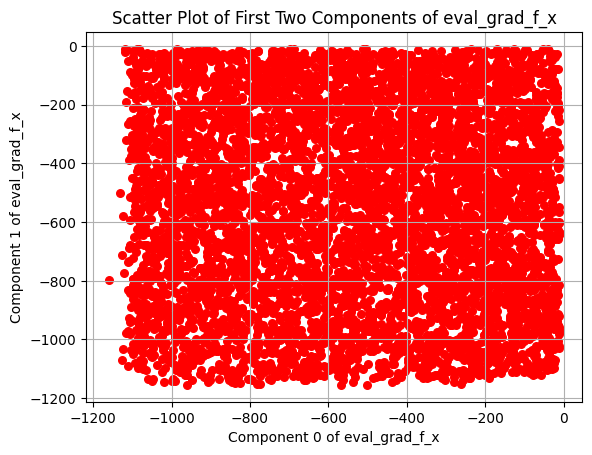

Residual along axis 0 @ value = -505.0: 4.189168930053711


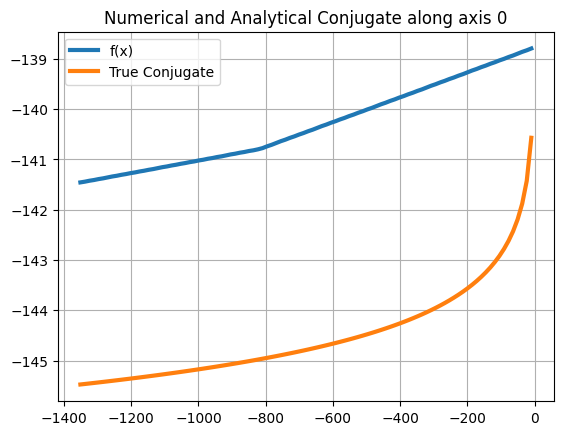

Residual along axis 1 @ value = -505.0: 4.406991481781006


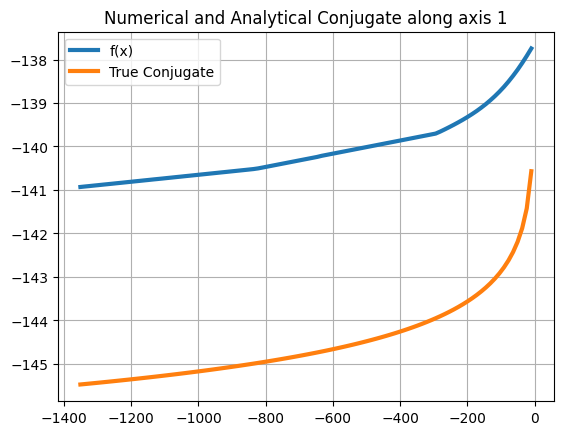

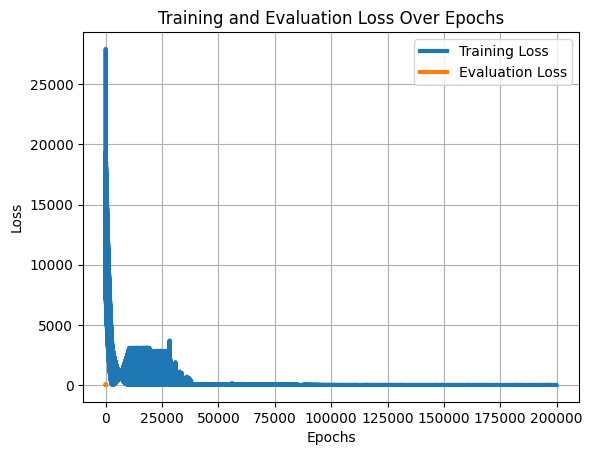

-1000 -10


In [ ]:
const_val = (minval + maxval)/2

plot_results(d, eval_grad_f_x, preds, vmap_f_star_true, state, const_val, train_losses, eval_losses)

print(minval, maxval)

In [ ]:
# loss_list = [float(value) for value in Loss]

# # Print the result
# print(loss_list)

In [ ]:
# eval_batch_x, eval_y, eval_grad_f_x = get_next_batch(train_x)
# preds = jnp.squeeze(state.apply_fn({'params': state.params}, eval_grad_f_x)).reshape(-1, 1)
# accuracy,acc_max, residual, mre = calculate_statistics(eval_batch_x, eval_grad_f_x, preds, vmap_f_star_true,  train_loss_list, eval_loss_list)
# print("Accuracy:", accuracy)
# print("Accuracy max norm:", acc_max)
# print("Accuracy, rel:", mre)
# print("Residual:", residual)


est Evaluation Results:

Evaluation after 140000 epochs:
Train Loss = 2.507253
Eval Loss = 2.414201
Best RMSE = 1.553770 at epoch 140000
Total Runtime = 0:39:11.149057

Measure approx_nu (approx_nu~nu in D) results
Accuracy = 1.5537700653076172, Max Accuracy = 7.43560791015625, RMSE = 1.553770, Mean Relative Error = 0.008870

Measure 'nu' results
Accuracy (y_nu) = 1.6681766510009766, Max Accuracy (y_nu) = 6.4945831298828125, Mean Relative Error (y_nu) = 0.009888
Additional Test on Test Set 2 after 140000 epochs:

Measure 'nabla f (mu)' (mu is uniform in C) results
Eval Loss 2 = 1.232406
Accuracy 2 = 1.1101375818252563, Max Accuracy 2 = 6.0169830322265625, RMSE 2 = 1.110138, Mean Relative Error 2 = 0.009919

### RESULTS FOR THE DLT PAPER:
d = 20
L2 Accuracy = 1.1101375818252563 (direct sampling)
L-2 Accuracy (y_nu) =  1.6681766510009766 (target uniform measure)

Train the best example Runtime = 39:11
Total runtime for 200k itereations = 56:10

Autoencoder training runtime: 45.77 seconds
Autoencoder loss: 2.8394